In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats


df1 = pd.read_csv('/content/drive/MyDrive/Rick- Anomaly Detection/Data/Yang/Matrix_sensor_pathx6_v2.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Rick- Anomaly Detection/Data/Yang/Matrix_sensor_pathx7_v2.csv')
df1 = df1.drop(columns=['Unnamed: 0'])
df2 = df2.drop(columns=['Unnamed: 0'])
df1.columns = ['protected_sensor2', 'sensor2_1', 'sensor2_2', 'sensor2_3', 'sensor2_4', 'sensor2_5']
df1.head()

,protected_sensor2,sensor2_1,sensor2_2,sensor2_3,sensor2_4,sensor2_5
0,100.002230,100.030760,100.006639,100.010475,100.004386,99.993849
1,100.004620,100.007231,99.993628,100.001745,99.998299,100.007774
2,99.990556,100.021548,100.002476,100.016218,100.020387,100.004963
3,100.010045,100.009612,100.009995,99.983677,100.003891,99.985096
4,100.008975,100.006153,100.004754,100.029630,100.019419,99.994599


<function matplotlib.pyplot.show(close=None, block=None)>

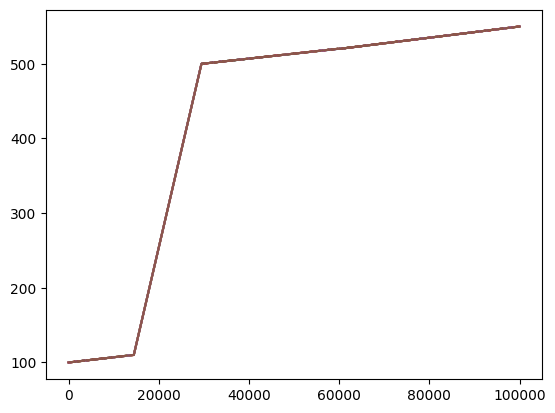

In [3]:
plt.plot(range(len(df2['protected_sensor'])), df2['protected_sensor'])
plt.plot(range(len(df2['sensor1'])), df2['sensor1'])
plt.plot(range(len(df2['sensor2'])), df2['sensor2'])
plt.plot(range(len(df2['sensor3'])), df2['sensor3'])
plt.plot(range(len(df2['sensor4'])), df2['sensor4'])
plt.plot(range(len(df2['sensor5'])), df2['sensor5'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

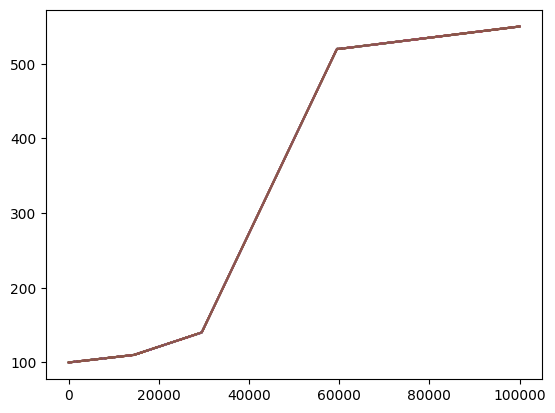

In [4]:

plt.plot(range(len(df1['protected_sensor2'])), df1['protected_sensor2'])
plt.plot(range(len(df1['sensor2_1'])), df1['sensor2_1'])
plt.plot(range(len(df1['sensor2_2'])), df1['sensor2_2'])
plt.plot(range(len(df1['sensor2_3'])), df1['sensor2_3'])
plt.plot(range(len(df1['sensor2_4'])), df1['sensor2_4'])
plt.plot(range(len(df1['sensor2_5'])), df1['sensor2_5'])
plt.show

In [5]:
# s1 = df1['protected_sensor']
# s2 = df1['sensor1']
# s3 = df2['sensor1']

df = pd.concat([df2, df1], axis=1)
df = df.drop(df.columns[[6, 8, 9, 10, 11]],axis = 1)
df.head()

,protected_sensor,sensor1,sensor2,sensor3,sensor4,sensor5,sensor2_1
0,99.992373,99.984200,99.999060,100.001885,100.006276,100.001059,100.030760
1,99.997782,99.995922,100.010142,99.992102,100.008734,100.002090,100.007231
2,100.010851,99.992947,99.996858,100.011251,100.001076,100.006651,100.021548
3,100.004997,100.014041,99.992742,100.018334,99.999045,100.006077,100.009612
4,100.021946,100.012357,100.004608,99.970872,99.998755,99.970316,100.006153


<function matplotlib.pyplot.show(close=None, block=None)>

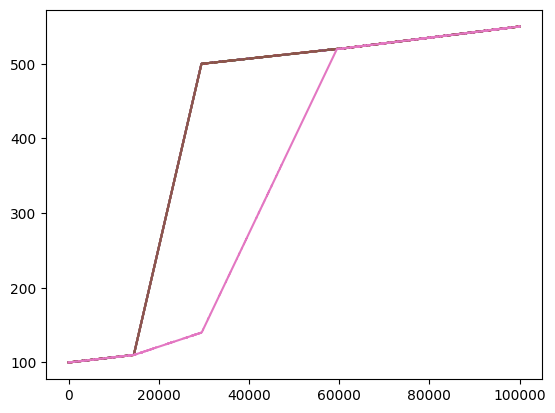

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



plt.plot(range(len(df['protected_sensor'])), df['protected_sensor'])
plt.plot(range(len(df['sensor1'])), df['sensor1'])
plt.plot(range(len(df['sensor2'])), df['sensor2'])
plt.plot(range(len(df['sensor3'])), df['sensor3'])
plt.plot(range(len(df['sensor4'])), df['sensor4'])
plt.plot(range(len(df['sensor5'])), df['sensor5'])
plt.plot(range(len(df['sensor2_1'])), df['sensor2_1'])

plt.show

In [7]:
# Trying dynamic time wrapping

# from dtaidistance import dtw
# from dtaidistance import dtw_visualisation as dtwvis
# import random
# import numpy as np


# path = dtw.warping_path(s1, s2)
# dtwvis.plot_warping(s1, s2, path)
# distance = dtw.distance(s1, s2)

# Taking predefined std. deviation for an unattacked system

obs_std = []
for i in range(1, 14350):
  array = np.array(df[i:i+1]).flatten()
  std = np.std(array, axis = 0)
  obs_std = obs_std + [std]


In [8]:
import numpy as np
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
# from tadgan_tf2 import preprocessing


import tensorflow as tf
import time

from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Dense, Conv1D, UpSampling1D, Cropping1D, \
    LSTM, Bidirectional, TimeDistributed, LeakyReLU, Dropout, Flatten, Reshape

In [9]:
# Functions for preprocessing of data


def rolling_windows(x, t, window_size, step_size=1):
    """Split time series data into rolling windows.

    The time series data (x) are expected to be an nD array, with n >= 1 and
    of the shape (# time stamps, ...); and the time stamps (t) in the form of
    a 1D-array are expected to be provided separately.

    The outputs are the windowed data (x_win) in the form of an (n+1)D array
    of the shape (# windows, window size, ...); and start times of the windows
    (t_win).
    """
    assert len(x) == len(t)
    n_windows = (len(x) - window_size) // step_size + 1
    x_win = np.full((n_windows, window_size, *(x.shape[1:])), np.nan)
    for i in range(window_size):
        x_win[:, i] = x[i::step_size][:n_windows]
    t_win = t[::step_size][:n_windows]
    return x_win, t_win


def pre_proc_apply_pipeline(x, freq, window_size):

    '''Apply a pipeline of preprocessing steps to transform raw time series
    data into the required format for the reconstruction model (TadGAN).

    Parameters
    ----------
    x : pandas series indexed by datetimes
        Time series data.

    freq : str
        Resampling frequency, of the same format as the first argument of
        pandas.Series.resample().

    window_size : int
        Size of rolling windows of the preprocessed time series.

    Returns
    -------
    x : 1D-array
        Preprocessed time series.

    t : 1D-array
        Time stamps of x.

    x_win : 2D-array
        Rolling windows of the preprocessed time series, of the shape
        (# windows, window size).

    t_win : 1D-array
        Starting time stamps of the rolling windows.
    '''

    x = x.resample(freq).sum()
    x, t = x.to_numpy(), x.index.to_numpy()
    x = x.reshape(-1, 1)
    x = SimpleImputer().fit_transform(x)
    x = MinMaxScaler(feature_range=(-1, 1)).fit_transform(x)
    x = x.reshape(-1)
    x_win, t_win = rolling_windows(x, t, window_size)

    return x, t, x_win, t_win


In [10]:
# Post processing for data

def merge_rolling_windows(x_win, step_size=1):
    '''Merge rolling-window time series data into single time series by taking
    median values per time stamp.

    The rolling window data (x_win) is expected to be an nD array, with n >= 2
    and of the shape (# windows, window size, ...).

    The output is the combined time series (x) in the form of an (n-1)D array
    of the shape (# time stamps, ...).
    '''
    n_windows, window_size = x_win.shape[:2]
    n = (n_windows - 1) * step_size + window_size
    x_mult = np.full((n, window_size, *(x_win.shape[2:])), np.nan)
    for i in range(window_size):
        x_mult[i::step_size, i][:n_windows] = x_win[:, i]
    x = np.nanmedian(x_mult, axis=1)
    return x


def _window_with_pad(a, window, pad_value, win_first=False):
    '''Helper function. Split a sequence into rolling windows after some
    padding, so that the number of windows equals the length of the sequence.
    '''
    pad_sizes = [(0, 0)] * len(a.shape)
    pad_sizes[0] = (window // 2, window - window // 2 - 1)
    a = np.pad(a, pad_sizes, 'constant', constant_values=pad_value)
    dummy_id = np.zeros(a.shape[0])
    a, _ = rolling_windows(a, dummy_id, window)
    if win_first:
        a = np.transpose(a, (1, 0, *range(2, len(a.shape))))
    return a


def _batch_dtw(a1, a2):
    '''Calculate the dynamic time warping distances between pairs of time
    series in batch.

    The batches of time series (a1, a2) are expected to be nD arrays, with
    their first dimensions representing time and other dimensions identical.

    The output is the resulting batch of distances, as an (n-1)D array.
    '''
    assert a1.shape[1:] == a2.shape[1:]
    dtw = np.full((a1.shape[0]+1, a2.shape[0]+1, *(a1.shape[1:])), np.inf)
    dtw[0, 0] = 0
    for i in range(a1.shape[0]):
        for j in range(a2.shape[0]):
            dtw[i+1, j+1] = np.absolute(a1[i] - a2[j]) \
                + np.minimum(np.minimum(dtw[i, j+1], dtw[i+1, j]), dtw[i, j])
    return dtw[-1, -1]


def reconstruction_error_scores(x, x_recon, dtw_window=10, smooth_window=None, normalize=True):

    '''Evaluate the reconstruction of time series based on the rolling DTW
    (dynamic time warping) differences between the original and reconstructed
    series.

    Parameters
    ----------
    x, x_recon : nD arrays
        Original and reconstructed time series data. The arrays are expected to
        have the same shape, with the first dimension representing time.

    dtw_window : int
        Size of the rolling windows for calculation of DTW distances.
    smooth_window : int or None
        Size of the rolling windows for calculation of running averages. If
        None, no such smoothing is applied.

    normalize : bool
        Whether to normalize the scores.
    Returns
    -------
    scores : nD array
        Scores of reconstruction errors. The array has the same shape as the
        given time series data.
    '''

    assert x.shape == x_recon.shape

    # calculate rolling DTW distances between original and reconstructed series
    x_win = _window_with_pad(x, dtw_window, 0, win_first=True)
    x_recon_win = _window_with_pad(x_recon, dtw_window, 0, win_first=True)
    scores = _batch_dtw(x_win, x_recon_win)
    del x_win, x_recon_win

    # smooth score series by taking rolling averages
    if smooth_window:
        scores = np.nanmean(_window_with_pad(scores, smooth_window, np.nan), axis=1)

    # normalize scores (and take positive part only)
    if normalize:
        mean, sd = np.mean(scores, axis=0), np.std(scores, axis=0)
        scores = np.maximum(scores - mean, 0) / (sd + 1e-8)

    return scores


def _kde_mode(a):
    '''Find the element of a sequence with the highest Gaussian KDE.'''
    a = a[~np.isnan(a)]
    if len(a) == 1 or a.std() == 0.0:
        return a.mean()
    kde = stats.gaussian_kde(a)(a)
    mode = a[np.argmax(kde)]
    return mode


def unroll_critic_scores(scores_win, window_size, step_size=1, smooth_window=None, normalize=True):

    '''Transform critic scores associated to rolling windows (as produced by
    the reconstruction model) into values associated to individual time stamps.

    Parameters
    ----------
    scores_win : nD array
        Critic scores associated to rolling windows, of the shape (# windows,
        ...).

    window_size : int
        Size of the underlying rolling windows.

    step_size : int
        Number of time stamps between successive windows.

    smooth_window : int or None
        Size of the rolling windows for calculation of running averages. If
        None, no such smoothing is applied.

    normalize : bool
        Whether to normalize the scores.

    Returns
    -------
    scores : nD array
        Transformed critic scores, of the shape (# time stamps, ...).
    '''

    # take the majority value (in the sense of maximal Gaussian KDE) among the
    # scores associated to the rolling windows covering each time stamp
    n_windows = scores_win.shape[0]
    n = (n_windows - 1) * step_size + window_size
    scores_mult = np.full((n, window_size, *scores_win.shape[1:]), np.nan)
    for i in range(window_size):
        scores_mult[i::step_size, i][:n_windows] = scores_win
    scores = np.apply_along_axis(_kde_mode, 1, scores_mult)
    del scores_mult

    # smooth score series by taking rolling averages
    if smooth_window:
        scores = np.nanmean(_window_with_pad(scores, smooth_window, np.nan), axis=1)

    # normalize scores and take absolute values
    # Note: Unlike the original version, the mean is taken over all values
    # instead of only the values in the middle two quartiles.
    if normalize:
        mean, sd = np.mean(scores, axis=0), np.std(scores, axis=0)
        scores = np.absolute(scores - mean) / (sd + 1e-8)

    return scores


def _consec_seqs(bools):
    '''Locate the consecutive sequences of True in a 1D array of Booleans.'''
    starts = np.argwhere(bools & np.insert(~bools[:-1], 0, True)).flatten()
    ends = np.argwhere(bools & np.append(~bools[1:], True)).flatten() + 1
    return np.stack([starts, ends], axis=1)


def _find_local_anomalies(scores, threshold, pad=None):
    '''Locate consecutive sequences of scores exceeding a threshold, with the
    option of including positions within a given distance (pad).

    The scores are expected to be a 1D array.

    The outputs consist of a pandas data frame containing the endpoints of, and
    maximum score within, each sequence; as well as the maximum score outside
    all sequences.
    '''
    # locate sequences of scores exceeding the threshold
    anomalous = (scores > threshold)
    seqs = _consec_seqs(anomalous)

    # include positions within a given distance
    if pad and (pad > 0):
        for start, end in seqs:
            anomalous[max(start - pad, 0) : start] = True
            anomalous[end : min(end + pad, len(scores))] = True
        seqs = _consec_seqs(anomalous)

    # attach max scores within each sequence / outside all
    seqs = pd.DataFrame(seqs, columns=['start', 'end'])
    seqs['max_score'] = seqs.apply(lambda x: scores[x['start'] : x['end']].max(), axis=1)
    max_score_rest = 0 if anomalous.all() else scores[~anomalous].max()

    return seqs, max_score_rest


def identify_anomalous_sequences(scores, t, sd_threshold=4.0, pad=None,
                                 local_window=None, local_window_step=None, prune_param=None):

    '''Identify anomalous sequences in a series of scores. A score is flagged
    as anomalous if it exceeds the mean score by a specified number of standard
    deviations; and this is carried out in the context of the entire series
    (global anomalies) as well as specified segments of it (local anomalies).
    Any overlapping sequences thus obtained are subsequently merged.
    Parameters
    ----------
    scores : 1D array
        Scores used to identify anomalous sequences.

    t : 1D array
        Underlying time stamps associated to the scores.

    sd_threshold : float
        Threshold for a score to be considered anomalous, as measured in number
        of standard deviations from the mean.

    pad : int or None
        Number of extra time stamps to be included at both ends of each
        anomalous sequence. If None, no extra time stamps are included.

    local_window : int or None
        Size of rolling windows used in the search of local anomalies. If None,
        it is set to be 33% of the length of the series.

    local_window_step : int or None
        Number of steps between successive rolling windows used in the search
        of local anomalies. If None, it is set to be 10% of the length of the
        series.

    prune_param : float or None
        Parameter of a pruning procedure for the locally identified sequences.
        If None, no pruning is applied.

    Returns
    -------
    seqs : pandas DataFrame
        Identified anomalous sequences as indicated by the first and last time
        stamps (start, end), together with associated scores (score).
    '''

    n = len(scores)
    local_window = local_window or int(n * 0.33)
    local_window_step = local_window_step or int(n * 0.1)
    all_local_seqs = []

    for window, step in [(n, 1), (local_window, local_window_step)]:

        n_windows = (n - window - 1) // step + 2
        for i in range(n_windows):

            window_start = i * step
            local_scores = scores[window_start : window_start + window]
            mean, sd = local_scores.mean(), local_scores.std()

            # identify anomalies based on a threshold
            threshold = mean + sd * sd_threshold
            if local_scores.max() <= threshold:
                continue
            local_seqs, max_score_rest = _find_local_anomalies(local_scores, threshold, pad=pad)

            # prune anomalous sequences based on the max scores therein
            if prune_param:  # Orion: 0.1
                local_seqs = local_seqs.sort_values('max_score', ascending=False, ignore_index=True)
                max_scores = local_seqs['max_score'].to_numpy()
                max_score_drops = 1 - np.append(max_scores[1:], max_score_rest) / max_scores
                if max_score_drops.max() <= prune_param:
                    continue
                cutoff = np.argwhere(max_score_drops > prune_param).max() + 1
                local_seqs = local_seqs.iloc[:cutoff]

            # replace local indices by global ones
            local_seqs[['start', 'end']] += window_start

            # normalize associated scores
            local_seqs['score'] = (local_seqs['max_score'] - mean) / (sd + 1e-8)
            local_seqs = local_seqs.drop('max_score', axis=1)

            all_local_seqs.append(local_seqs)

    if len(all_local_seqs) == 0:
        return pd.DataFrame(columns=['start', 'end', 'score'])

    # merge overlapping sequences and associated scores
    all_local_seqs = pd.concat(all_local_seqs)
    score_densities = np.zeros(n)
    for _, x in all_local_seqs.iterrows():
        score_densities[int(x['start']) : int(x['end'])] += x['score']
    seqs = _consec_seqs(score_densities > 0)
    seqs = pd.DataFrame(seqs, columns=['start', 'end'])
    seqs['score'] = seqs.apply(lambda x: score_densities[x['start'] : x['end']].mean(), axis=1)

    # replace indices by underlying time stamps
    seqs['start'] = seqs['start'].apply(lambda i: t[i])
    seqs['end'] = seqs['end'].apply(lambda i: t[i-1])

    return seqs


def apply_pipeline(x, t, x_win_recon, critic_scores, **params):

    '''Apply a pipeline of postprocessing steps taking outputs of the
    reconstruction model and producing the identified anomalous sequences.

    Parameters
    ----------
    x : 1D-array
        Original time series.

    t : 1D-array
        Time stamps of x.

    x_win_recon : 2D-array
        Reconstructed rolling windows of x.

    critic_scores : 1D-array
        Raw critic scores from the reconstruction model (TadGAN).

    params : dict
        Parameters of the postprocessing steps. The possible key-value pairs
        include:
        - 'recon_score_params': kwargs of reconstruction_error_scores()
        - 'critic_score_params': kwargs of unroll_critic_scores()
        - 'anomalous_seq_params': kwargs of identify_anomalous_sequences()

    Returns
    -------
    seqs : pandas DataFrame
        Anomalous sequences detected, including their starting and ending time
        stamps and associated scores.
    x_recon : 1D-array
        Reconstructed time series.

    combined_scores : 1D-array
        Scores used in the identification of anomalous sequences, based on
        reconstruction errors and critic scores.
    '''

    recon_score_params = params.get('recon_score_params', {})
    critic_score_params = params.get('critic_score_params', {})
    anomalous_seq_params = params.get('anomalous_seq_params', {})

    window_size = x_win_recon.shape[1]
    x_recon = merge_rolling_windows(x_win_recon)
    recon_scores = reconstruction_error_scores(x, x_recon, **recon_score_params)
    critic_scores = unroll_critic_scores(critic_scores, window_size, **critic_score_params)
    combined_scores = recon_scores + critic_scores
    seqs = identify_anomalous_sequences(combined_scores, t, **anomalous_seq_params)

    return seqs, x_recon, combined_scores


In [11]:
def _wasserstein_loss(y_true, y_pred):  # y_true = 1 or -1
    return tf.reduce_mean(y_true * y_pred)


class _RandomWeightedMean(Layer):
    """Subclass of tf.keras.layers.Layer for computing a randomly weighted mean
    of two given tensors.
    """
    def call(self, inputs):
        x0, x1 = inputs
        t = tf.random.uniform(x0.shape[1:])
        return x0 * (1 - t) + x1 * t


class _GradientSquared(Layer):
    """Subclass of tf.keras.layers.Layer for computing the gradient squared of
    a function at a given tensor.
    """

    def __init__(self, fn):
        super(_GradientSquared, self).__init__()
        self.fn = fn

    def call(self, inputs):
        with tf.GradientTape() as tape:
            tape.watch(inputs)
            val = tf.reduce_sum(self.fn(inputs))
        grad = tape.gradient(val, inputs)
        grad_sq = tf.reduce_sum(grad ** 2, axis=range(1, len(inputs.shape)))
        return grad_sq

In [12]:
class TadGAN(object):

    """Class of a GAN-based time series reconstruction model that was first
    developed in https://arxiv.org/abs/2009.07769v3 and aims to reconstruct
    non-anomalous parts of time series.

    The model has the following components:
    - The encoder embeds any time series into a latent space.
    - The generator creates a time series from any vector in the latent space.
    - The input space critic evaluates a scalar score for any time series.
    - The latent space critic evaluates a scalar score for any vector in the
      latent space.

    Training alternates between two stages. During one stage, the input space
    critic learns to differentiate real time series from generatated ones, and
    the latent space critic learns to differentiate random vectors in the
    latent space from embeddings of real time series. During the other stage,
    the encoder and generator learn to fool the two critics and also recover
    real time series together.

    After training, the model reconstructs time series by combining actions of
    the encoder and the generator.
    """

    def __init__(self, **params):
        self.input_dim = params.get('input_dim', 100)
        self.latent_dim = params.get('latent_dim', 20)
        lr = params.get('learning_rate', 0.0001)
        # self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        self.optimizer = tf.keras.optimizers.legacy.Adam()
        self.encoder_params = params.get('encoder', {})
        self.generator_params = params.get('generator', {})
        self.critic_x_params = params.get('critic_x', {})
        self.critic_z_params = params.get('critic_z', {})

    def _build(self):

        # architecture of encoder

        LSTM_units = self.encoder_params.get('LSTM_units', 100)

        self.encoder = Sequential([
            Reshape((self.input_dim, 1)),
            Bidirectional(LSTM(LSTM_units, return_sequences=True)),
            Flatten(),
            Dense(self.latent_dim)
        ])

        # architecture of generator
        # Note: Unlike the original implementation, recurrent dropout is turned
        # off for the use of cuDNN kernel.

        int_dim, crop_dim = (self.input_dim + 1) // 2, self.input_dim % 2
        LSTM_units = self.generator_params.get('LSTM_units', 64)
        LSTM_dropout = self.generator_params.get('LSTM_dropout', 0.2)

        self.generator = Sequential([
            Dense(int_dim),
            Reshape((int_dim, 1)),
            Bidirectional(LSTM(LSTM_units, return_sequences=True, dropout=LSTM_dropout)),
            UpSampling1D(size=2), Cropping1D(cropping=(0, crop_dim)),
            Bidirectional(LSTM(LSTM_units, return_sequences=True, dropout=LSTM_dropout)),
            TimeDistributed(Dense(1, activation='tanh')),
            Flatten()
        ])

        # architecture of input space critic

        conv_filters = self.critic_x_params.get('conv_filters', 64)
        leakyrelu_slope = self.critic_x_params.get('leakyrelu_slope', 0.2)
        dropout = self.critic_x_params.get('dropout', 0.25)

        self.critic_x = Sequential([
            Reshape((self.input_dim, 1)),
            Conv1D(conv_filters, 5), LeakyReLU(alpha=leakyrelu_slope), Dropout(dropout),
            Conv1D(conv_filters, 5), LeakyReLU(alpha=leakyrelu_slope), Dropout(dropout),
            Conv1D(conv_filters, 5), LeakyReLU(alpha=leakyrelu_slope), Dropout(dropout),
            Conv1D(conv_filters, 5), LeakyReLU(alpha=leakyrelu_slope), Dropout(dropout),
            Flatten(),
            Dense(1)
        ])

        # architecture of latent space critic

        int_dim = self.critic_z_params.get('int_dim', 100)
        leakyrelu_slope = self.critic_z_params.get('leakyrelu_slope', 0.2)
        dropout = self.critic_z_params.get('dropout', 0.2)

        self.critic_z = Sequential([
            Dense(int_dim), LeakyReLU(alpha=leakyrelu_slope), Dropout(dropout),
            Dense(int_dim), LeakyReLU(alpha=leakyrelu_slope), Dropout(dropout),
            Dense(1)
        ])

        # training configuration of critics

        x = Input(shape=(self.input_dim,))
        z = Input(shape=(self.latent_dim,))

        self.encoder.trainable = False
        self.generator.trainable = False
        self.critic_x.trainable = True
        self.critic_z.trainable = True

        z_enc = self.encoder(x)
        x_gen = self.generator(z)

        score_x = self.critic_x(x)
        score_x_gen = self.critic_x(x_gen)

        x_mixed = _RandomWeightedMean()([x, x_gen])
        cx_grad_sq = _GradientSquared(self.critic_x)(x_mixed)

        self.critic_x_model = Model(inputs=[x, z], outputs=[score_x, score_x_gen, cx_grad_sq])
        self.critic_x_model.compile(loss=[_wasserstein_loss, _wasserstein_loss, 'mse'],
                                    loss_weights=[1, 1, 10],
                                    optimizer=self.optimizer)

        score_z = self.critic_z(z)
        score_z_enc = self.critic_z(z_enc)

        z_mixed = _RandomWeightedMean()([z, z_enc])
        cz_grad_sq = _GradientSquared(self.critic_z)(z_mixed)

        self.critic_z_model = Model(inputs=[x, z], outputs=[score_z, score_z_enc, cz_grad_sq])
        self.critic_z_model.compile(loss=[_wasserstein_loss, _wasserstein_loss, 'mse'],
                                    loss_weights=[1, 1, 10],
                                    optimizer=self.optimizer)

        # training configuration of encoder and generator

        self.encoder.trainable = True
        self.generator.trainable = True
        self.critic_x.trainable = False
        self.critic_z.trainable = False

        z_enc = self.encoder(x)
        x_gen = self.generator(z)
        x_recon = self.generator(z_enc)

        score_x_gen = self.critic_x(x_gen)
        score_z_enc = self.critic_z(z_enc)

        self.encoder_generator_model = Model(inputs=[x, z],
                                             outputs=[score_x_gen, score_z_enc, x_recon])
        self.encoder_generator_model.compile(loss=[_wasserstein_loss, _wasserstein_loss, 'mse'],
                                             loss_weights=[1, 1, 10],
                                             optimizer=self.optimizer)

    def fit(self, x, batch_size=64, encoder_generator_freq=5, epochs=20):
        """Train the model with a collection of time series (x) and random
        vectors in the latent space sampled from a normal distribution.

        The time series (x) are expected to be a 2D-array, of the shape
        (# samples, # time stamps).

        In each epoch, the time series are shuffled randomly and divided into
        mini-batches. While every mini-batch is used to generate a training
        step for the critics, only every kth mini-batch is used to do so for
        the encoder and generator (k = encoder_generator_freq).
        """

        n_samples, input_dim = x.shape
        assert self.input_dim == input_dim

        self._build()

        n_batches = n_samples // batch_size
        ones = np.ones((batch_size, 1))

        for epoch in range(epochs):

            t0 = time.time()

            idx = np.random.permutation(n_samples)
            critic_x_losses, critic_z_losses, encoder_generator_losses = [], [], []

            for batch in range(n_batches):

                idx_batch = idx[batch_size * batch: batch_size * (batch + 1)]
                x_batch = x[idx_batch]
                z_batch = np.random.normal(size=(batch_size, self.latent_dim))

                # training step of each critic

                critic_x_losses.append(
                    self.critic_x_model.train_on_batch([x_batch, z_batch], [-ones, ones, ones])
                )

                critic_z_losses.append(
                    self.critic_z_model.train_on_batch([x_batch, z_batch], [-ones, ones, ones])
                )

                # training step of encoder + generator

                if (batch + 1) % encoder_generator_freq == 0:
                    encoder_generator_losses.append(
                        self.encoder_generator_model.train_on_batch(
                            [x_batch, z_batch], [-ones, -ones, x_batch]
                        )
                    )

            # Note: In each of the following arrays, the 0th element is the
            # total (weighted) loss, and the rest its respective components.

            critic_x_losses = np.mean(np.array(critic_x_losses), axis=0)
            critic_z_losses = np.mean(np.array(critic_z_losses), axis=0)
            encoder_generator_losses = np.mean(np.array(encoder_generator_losses), axis=0)

            t1 = time.time()

            print(f'Epoch {epoch+1}/{epochs} ({t1-t0:.1f} secs)')
            print(f'  Critic X Loss: {critic_x_losses[0]:.6f} {critic_x_losses[1:]}')
            print(f'  Critic Z Loss: {critic_z_losses[0]:.6f} {critic_z_losses[1:]}')
            print(f'  Encoder Generator Loss: {encoder_generator_losses[0]:.6f} {encoder_generator_losses[1:]}')


    def predict(self, x):
        """Generate reconstruction of a collection of time series (x), via the
        encoder and the generator.
        The time series (x) are expected to be a 2D-array, of the shape
        (# samples, # time stamps).

        The outputs consist of the reconstructed time series (x_recon) as a
        2D-array of the same shape, as well as the input space critic scores of
        the given time series (critic_score) as a 1D-array.
        """
        x_recon = self.generator(self.encoder(x)).numpy()
        critic_score = self.critic_x(x).numpy()[:, 0]
        return x_recon, critic_score

In [13]:
# Utilities - plotting

def plot_time_series(t, x, x_win=None, labeled_intervals=None, detected_intervals=None,
                     date_range=None, value_range=None, title=None):

    """Plot a time series, together with any of the following details:
    - a collection of related time series over rolling windows
    - labeled anomalous intervals
    - detected anomalous intervals

    Paramters
    ---------
    t, x : 1D arrays
        Time stamps and values of a time series.

    x_win : 2D array or None
        A collection of time series over rolling windows.

    labeled_intervals, detected_intervals : 2D arrays or None
        Labeled and detected intervals, each of the shape (# intervals, 2).
    date_range : list of datetimes, or None
        Left and right limits of the time axis. If None, the start and end of t
        are used.

    value_range : list or None
        Lower and upper limits of the vertical axis.

    title : str
        Title of the plot.
    """

    if date_range is not None:
        date_range = [np.datetime64(d) for d in date_range]
    else:
        date_range = [t[0], t[-1]]

    plt.figure(figsize=(15, 5))
    mask = (t >= date_range[0]) & (t <= date_range[1])
    plt.plot(t[mask], x[mask], color='blue')

    if x_win is not None:
        n_windows, window_size = x_win.shape
        for i in range(n_windows):
            if (t[i] <= date_range[1]) & (t[i + window_size - 1] >= date_range[0]):
                plt.plot(t[i : i + window_size], x_win[i], color='red', alpha=0.1, lw=1.0)

    if labeled_intervals is not None:
        for start, end in labeled_intervals:
            if (start <= date_range[1]) & (end >= date_range[0]):
                plt.axvspan(start, end, color='blue', alpha=0.2)

    if detected_intervals is not None:
        for start, end in detected_intervals:
            if (start <= date_range[1]) & (end >= date_range[0]):
                plt.axvspan(start, end, color='red', alpha=0.2)

    plt.xlim(date_range)
    if value_range:
        plt.ylim(value_range)
    if title:
        plt.title(title)

    plt.show()


def evaluate_detected_anomalies(labeled_intervals, detected_intervals):

    """Calculate recall, precision and F1-score of the detected anomalous
    intervals with reference to the labeled ones.
    """

    unit = np.timedelta64(1, 'D')
    len_labeled, len_detected, len_overlap = 0, 0, 0

    for start, end in labeled_intervals:
        len_labeled += (end - start) / unit

    for start, end in detected_intervals:
        len_detected += (end - start) / unit

    for start1, end1 in labeled_intervals:
        for start2, end2 in detected_intervals:
            start, end = max(start1, start2), min(end1, end2)
            if start < end:
                len_overlap += (end - start) / unit

    recall = len_overlap / len_labeled
    precision = len_overlap / len_detected
    f1 = 2 * recall * precision / (recall + precision + 1e-8)

    return recall, precision, f1



In [14]:
# preprocessing
RESAMPLE_FREQ = 's'
WINDOW_SIZE = 25

# reconstruction model (TadGAN)
LATENT_DIM = 20
ENCODER_PARAMS = {'LSTM_units': 100}
GENERATOR_PARAMS = {'LSTM_units': 64, 'LSTM_dropout': 0.2}
LEARNING_RATE = 0.0001
EPOCHS = 5

# postprocessing
RECON_SCORE_PARAMS = {'dtw_window': 10}
ANOMALOUS_SEQ_PARAMS = {'sd_threshold': 4.0, 'pad': 50}

In [15]:
# Lets train TadGAN on a protected x sensor
path1_train = df


path1_sensor1_train = pd.DataFrame(path1_train['protected_sensor'])


# import time series
from datetime import datetime, timedelta

path1_sensor1_train['timestamp'] = pd.to_datetime('2023-03-02')
path1_sensor1_train['index'] = range(1, len(path1_sensor1_train) + 1)
path1_sensor1_train['timestamp'] = path1_sensor1_train['timestamp'] + pd.to_timedelta(path1_sensor1_train['index'], unit='s')
path1x1 = path1_sensor1_train[['timestamp', 'protected_sensor']]

path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))

path1x1 = path1x1.set_index('timestamp')['protected_sensor']


path1x1 = path1x1.astype(np.float64)

<ipython-input-15-139068cf0a62>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


In [16]:
# apply preprocessing pipeline
x= path1x1
x, t, x_win, t_win = pre_proc_apply_pipeline(x=x, freq=RESAMPLE_FREQ, window_size=WINDOW_SIZE)

In [17]:
# instantiate and configure a TadGAN model

params = {
    'input_dim': WINDOW_SIZE,
    'latent_dim': LATENT_DIM,
    'learning_rate': LEARNING_RATE,
    'encoder': ENCODER_PARAMS,
    'generator': GENERATOR_PARAMS
}

model = TadGAN(**params)


In [18]:

# train the model

# t0 = time.time()
model.fit(x_win, epochs=EPOCHS)
# t1 = time.time()

Epoch 1/5 (96.4 secs)
  Critic X Loss: -0.426745 [-0.1825344  -0.74840231  0.05041913]
  Critic Z Loss: -2.623926 [-2.96180336 -0.33130943  0.06691863]
  Encoder Generator Loss: 3.010208 [0.71620601 0.4583116  0.18356909]
Epoch 2/5 (73.0 secs)
  Critic X Loss: 0.125287 [-26.72564146  26.4556399    0.03952885]
  Critic Z Loss: -3.266558 [-3.25366333 -0.51696641  0.05040719]
  Encoder Generator Loss: -25.003589 [-26.43257898   0.55263228   0.08763578]
Epoch 3/5 (76.8 secs)
  Critic X Loss: 0.158209 [-15.64623915  15.50112833   0.03033199]
  Critic Z Loss: -3.082836 [-3.94650693  0.37984972  0.04838217]
  Encoder Generator Loss: -15.522290 [-15.45912657  -0.36401221   0.03008491]
Epoch 4/5 (75.9 secs)
  Critic X Loss: 0.234726 [ 2.43221702 -2.47518276  0.02776914]
  Critic Z Loss: -3.140730 [-4.0632543   0.44953159  0.04729923]
  Encoder Generator Loss: 2.291058 [ 2.50913189 -0.43451085  0.02164371]
Epoch 5/5 (74.8 secs)
  Critic X Loss: 0.222901 [ 12.61456615 -12.6289725    0.02373072]
 

In [19]:
# apply preprocessing pipeline
x= path1x1[:1000]
x, t, x_win, t_win = pre_proc_apply_pipeline(x=x, freq=RESAMPLE_FREQ, window_size=WINDOW_SIZE)

In [20]:
x.shape

(1000,)

In [21]:
# generate reconstructed time series segments

x_win_recon, critic_scores = model.predict(x_win)

In [22]:
x6_path_recons = x_win_recon

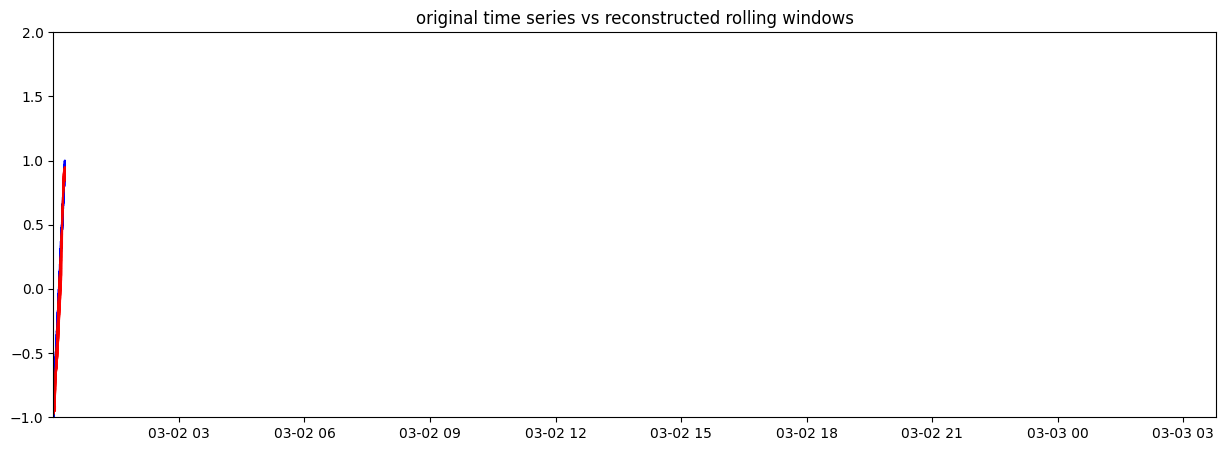

In [23]:
plot_time_series(t, x, x_win=x_win_recon,
                       date_range=['2023-03-02 00:00:01', '2023-03-03 03:46:40'], value_range=[-1, 2],
                       title='original time series vs reconstructed rolling windows')

## Functions to identify attacked sensors

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def find_attacked_sensor(sensor_data1, sensor_data2, protected_sensor_value, mean=0, std=0.1, sample_size1=1000, sample_size2=500, percentile_level=0.95):
    def get_difference_and_remove_margin_value(sensor, percentile_level):
        difference_set = []
        for i in range(len(sensor) - 1):
            difference = sensor[i + 1] - sensor[0]
            difference_set.append(difference)
        difference_set = np.array(difference_set)

        # Find the lower and upper bounds of the specified percentile level
        lower_bound = np.percentile(difference_set, (1 - percentile_level) / 2 * 100)
        upper_bound = np.percentile(difference_set, (1 + percentile_level) / 2 * 100)

        # Filter out values outside the percentile interval to get the training dataset
        mask = (difference_set >= lower_bound) & (difference_set <= upper_bound)
        Difference_after_remove = difference_set[mask]

        # Obtain the indices of the remaining values
        indices_after_remove = np.where(mask)[0]

        return Difference_after_remove, indices_after_remove

    def remove_outliers(training, testing):
        counts1, bins1 = np.histogram(training, bins=20)
        counts2, bins2 = np.histogram(testing, bins=20)

        counts3=(counts1/len(training))*1000
        counts4=(counts2/len(testing))*1000

        testing_after_remove = testing.copy()  # Create a copy of the testing array

        replaced_indices = []  # List to store the replaced indices

        for i in range(len(counts4)):
            #print(counts4[i])
            percent = 0.01
            if counts4[i] - counts3[i] > percent * counts3[i]:  # You can change the value of percent depending on your needs
               diff = int(counts4[i] - (1 + percent) * counts3[i])
               print(diff)
               indices = np.where((testing_after_remove >= bins2[i-1]) & (testing_after_remove < bins2[i]))[0]
               np.random.shuffle(indices)  # Randomize the indices
               replaced_indices.extend(indices[:diff]+1)  # Add the replaced indices to the list
               testing_after_remove[indices[:diff]] = -999  # Mark the removed values with -999 or any other desired marker

        replaced_indices.sort()  # Sort the replaced indices in ascending order
        #print("Indices Replaced by -999(indice of testing_after_remove):", replaced_indices)
        return testing_after_remove, replaced_indices

    def normalize_data(data):
        mean = np.mean(data)
        std = np.std(data)
        normalized_data = (data - mean) / std
        return normalized_data

    sensor = np.append(protected_sensor_value, sensor_data1)
    sensor1 = np.append(protected_sensor_value, sensor_data2)

    normalized_sensor = normalize_data(sensor)
    normalized_sensor1 = normalize_data(sensor1)

    Difference_training, remaining_indices_training = get_difference_and_remove_margin_value(normalized_sensor, percentile_level=0.95)
    Difference_testing, remaining_indices_testing = get_difference_and_remove_margin_value(normalized_sensor1, percentile_level=0.95)

    testing_after_remove, replaced_indices = remove_outliers(Difference_training, Difference_testing)

    attacked_sensor = []
    for i in replaced_indices:
        attacked_sensor1 = remaining_indices_testing[i-1]+1
        attacked_sensor.append(attacked_sensor1)

    return Difference_training,Difference_testing,attacked_sensor


# Train SAITS for missing value imputation

In [25]:
pip install pypots

In [26]:
# Install PyPOTS first: pip install pypots==0.1.1
import numpy as np
from sklearn.preprocessing import StandardScaler
from pypots.data import load_specific_dataset, mcar, masked_fill
from pypots.imputation import SAITS
from pypots.utils.metrics import cal_mae


In [27]:
# Data preprocessing. Tedious, but PyPOTS can help.
# data = load_specific_dataset('physionet_2012')  # For datasets in PyPOTS database, PyPOTS will automatically download and extract it.
X = df.to_numpy()

timesteps = 100
features = 7

number_of_samples = X.shape[0] // timesteps

X = X[:number_of_samples * timesteps, :].reshape(number_of_samples, timesteps, features)

X_intact, X, missing_mask, indicating_mask = mcar(X, 0.1) # hold out 10% observed values as ground truth
X = masked_fill(X, 1 - missing_mask, np.nan)

In [28]:
# Model training. This is PyPOTS showtime.
saits = SAITS(n_steps=100, n_features=7, n_layers=2, d_model=256, d_inner=128, n_heads=4, d_k=64, d_v=64, dropout=0.1, epochs=10)
dataset = {"X": X}
saits.fit(dataset)  # train the model. Here I use the whole dataset as the training set, because ground truth is not visible to the model.
imputation = saits.impute(dataset)  # impute the originally-missing values and artificially-missing values
mae = cal_mae(imputation, X_intact, indicating_mask)  # calculate mean absolute error on the ground truth (artificially-missing values)

2023-07-12 01:05:47 [INFO]: No given device, using default device: cuda
2023-07-12 01:05:47 [INFO]: saving_path not given. Model files and tensorboard file will not be saved.
2023-07-12 01:05:47 [INFO]: Model initialized successfully with the number of trainable parameters: 1,328,442
2023-07-12 01:05:49 [INFO]: epoch 0: training loss 379.0319
2023-07-12 01:05:50 [INFO]: epoch 1: training loss 197.6122
2023-07-12 01:05:51 [INFO]: epoch 2: training loss 160.6457
2023-07-12 01:05:52 [INFO]: epoch 3: training loss 108.4551
2023-07-12 01:05:53 [INFO]: epoch 4: training loss 68.6384
2023-07-12 01:05:54 [INFO]: epoch 5: training loss 49.2970
2023-07-12 01:05:55 [INFO]: epoch 6: training loss 36.6014
2023-07-12 01:05:56 [INFO]: epoch 7: training loss 30.2966
2023-07-12 01:05:57 [INFO]: epoch 8: training loss 26.8597
2023-07-12 01:05:58 [INFO]: epoch 9: training loss 25.0038
2023-07-12 01:05:58 [INFO]: Finished training.


In [ ]:
# scaler.inverse_transform(imputation)

imputation1 = pd.DataFrame(imputation.reshape(-1, X.shape[-1]))
imputation1.head()

In [ ]:
# training = get_difference_and_remove_margin_value(np.array(df[1:2]).flatten(), 0.95)


In [31]:
# testing = get_difference_and_remove_margin_value(np.array(df[2:3]).flatten(), 0.95)
import sys
import os
label_attack = find_attacked_sensor(np.array(df[1:2]).flatten(), np.array(df[20000:20000+1]).flatten(), np.array(df[1:2]).flatten()[0], mean=0, std=0.1, sample_size1=7, sample_size2=7, percentile_level=0.95)
label_attack

200
200


(array([ 0.        , -0.30007744,  1.76712678,  0.69520348,  1.52470187]),
 array([2.46984511, 2.47011881, 2.4701339 , 2.47002826, 2.47017758]),
 [])

In [29]:
def get_difference_and_remove_margin_value(sensor, percentile_level):
    difference_set = []
    for i in range(len(sensor) - 1):
        difference = sensor[i + 1] - sensor[0]
        difference_set.append(difference)
    difference_set = np.array(difference_set)

    # Find the lower and upper bounds of the specified percentile level
    lower_bound = np.percentile(difference_set, (1 - percentile_level) / 2 * 100)
    upper_bound = np.percentile(difference_set, (1 + percentile_level) / 2 * 100)

    # Filter out values outside the percentile interval to get the training dataset
    mask = (difference_set >= lower_bound) & (difference_set <= upper_bound)
    Difference_after_remove = difference_set[mask]

    # Obtain the indices of the remaining values
    indices_after_remove = np.where(mask)[0]

    return Difference_after_remove, indices_after_remove

In [46]:
label_attack = get_difference_and_remove_margin_value(np.array(df[20000:20000+1]).flatten(), percentile_level = 0.95)[1]

In [47]:
label_attack

array([0, 1, 3, 4])

In [40]:
print([l + 1 for l in list(label_attack)])

[1, 2, 4, 5]


[1, 2, 4, 5]

<ipython-input-32-98a4140d22f8>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


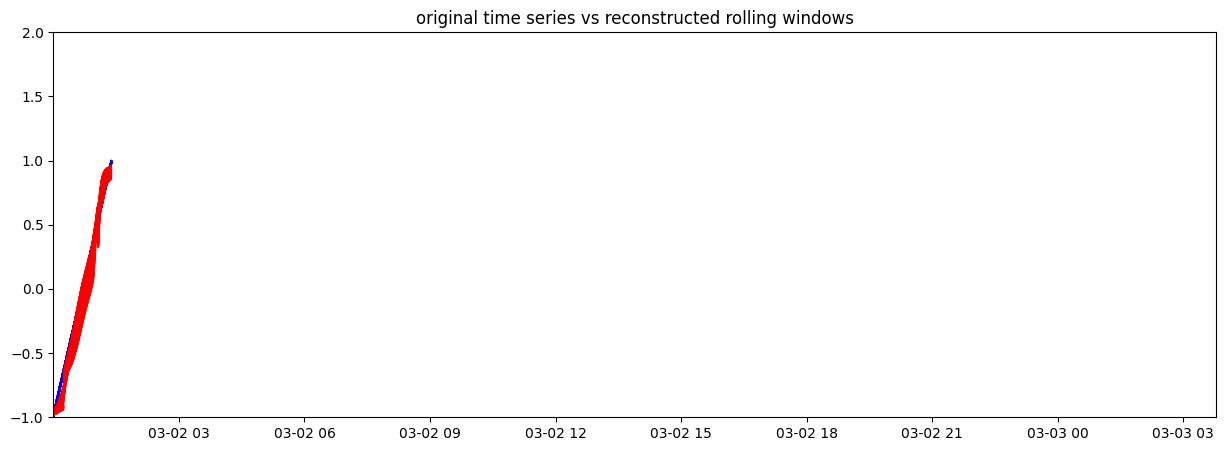

<ipython-input-32-98a4140d22f8>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


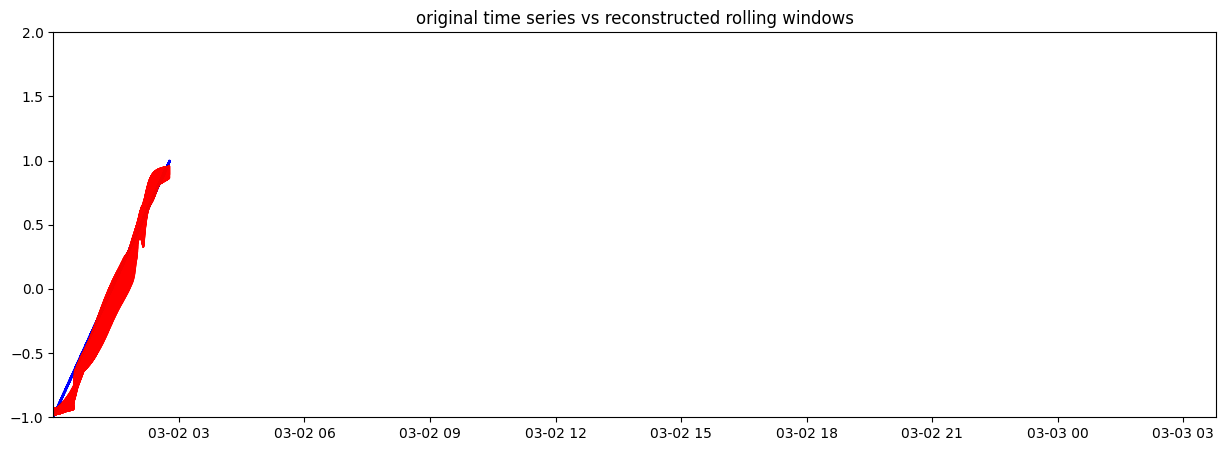

<ipython-input-32-98a4140d22f8>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


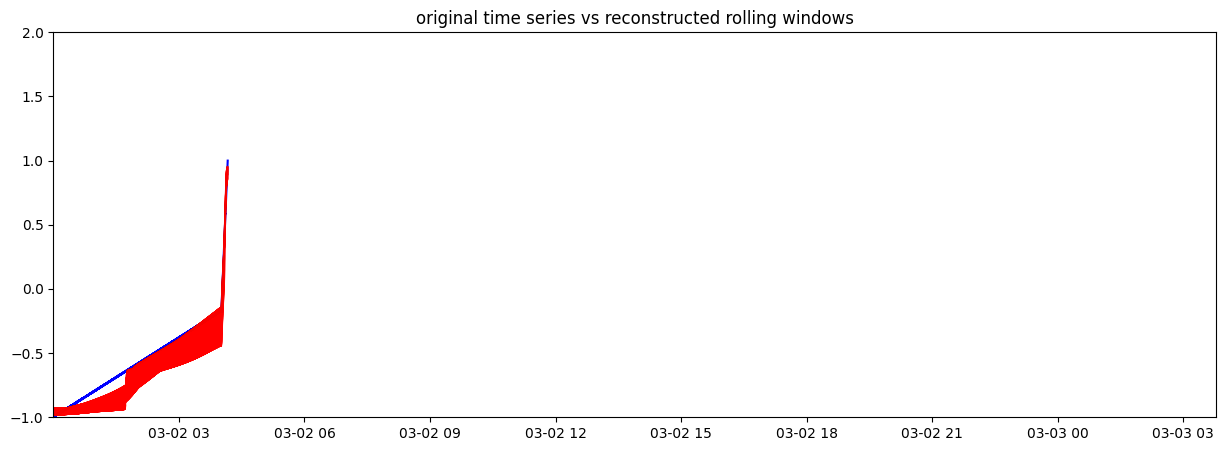

<ipython-input-32-98a4140d22f8>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


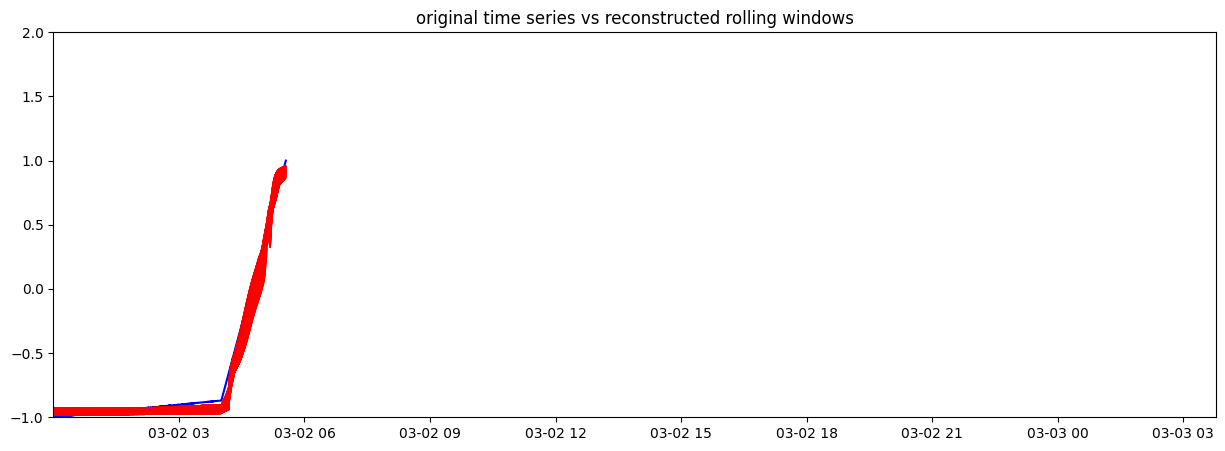

<ipython-input-24-da0013c55cbf>:30: RuntimeWarning: invalid value encountered in true_divide
  counts4=(counts2/len(testing))*1000
<ipython-input-32-98a4140d22f8>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


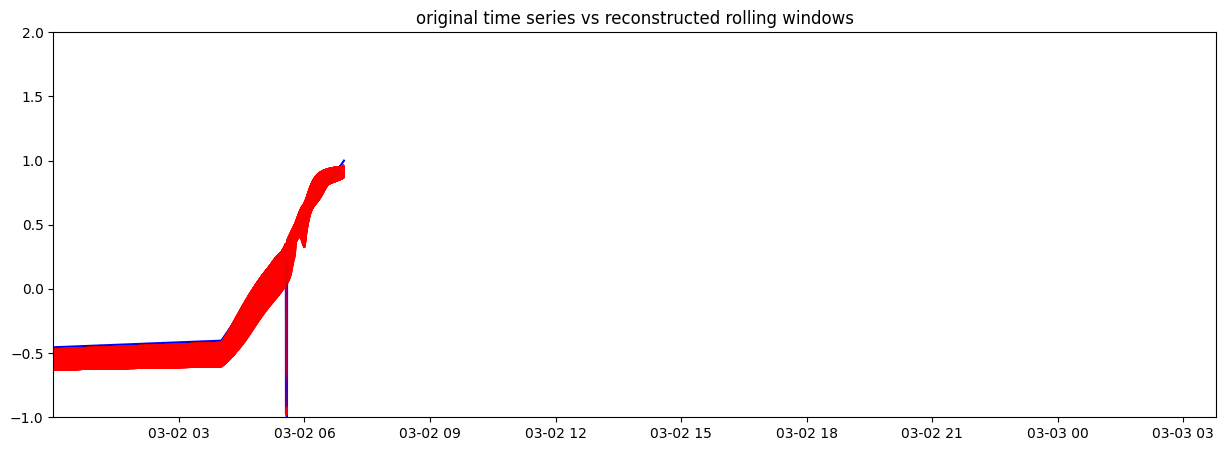

<ipython-input-32-98a4140d22f8>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


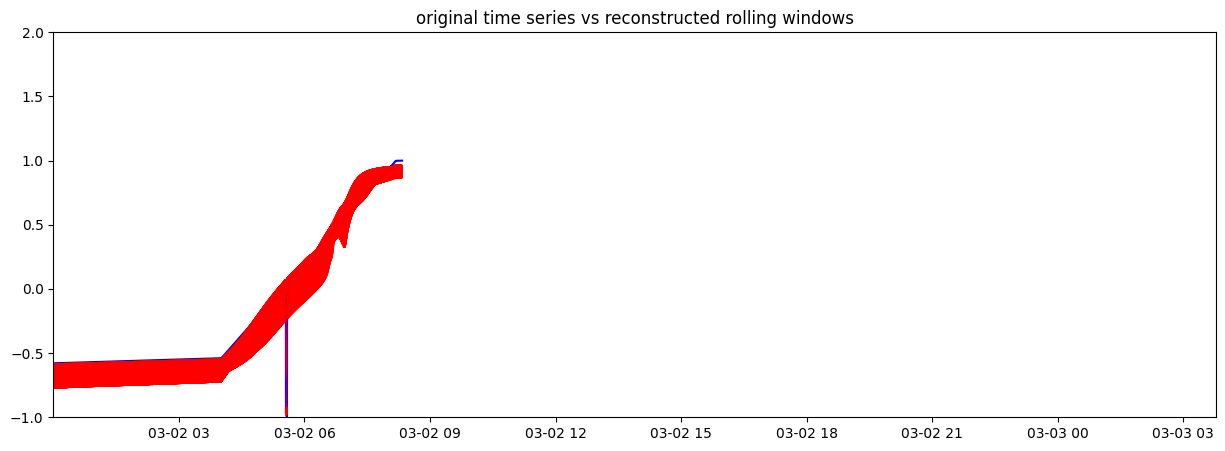

<ipython-input-32-98a4140d22f8>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


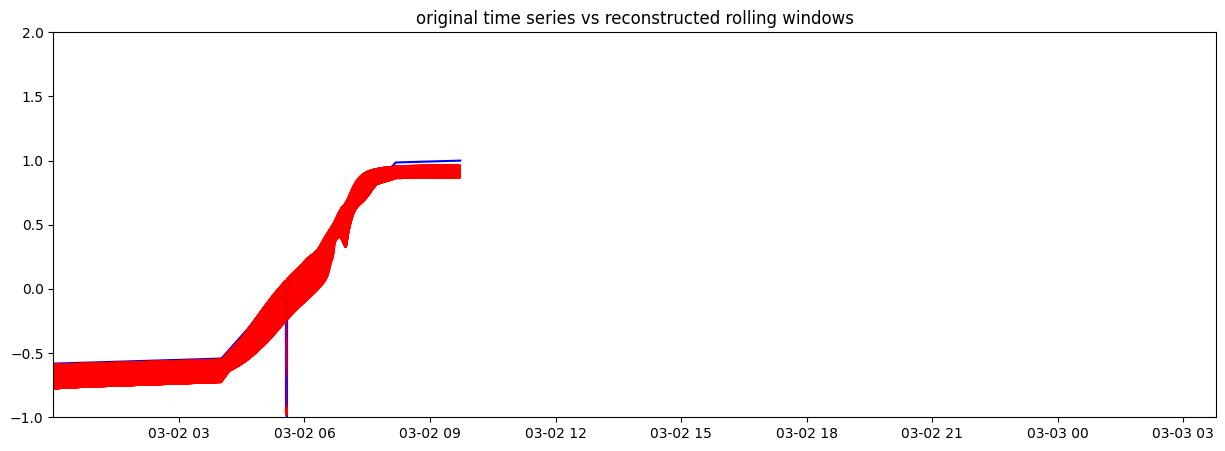

<ipython-input-32-98a4140d22f8>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


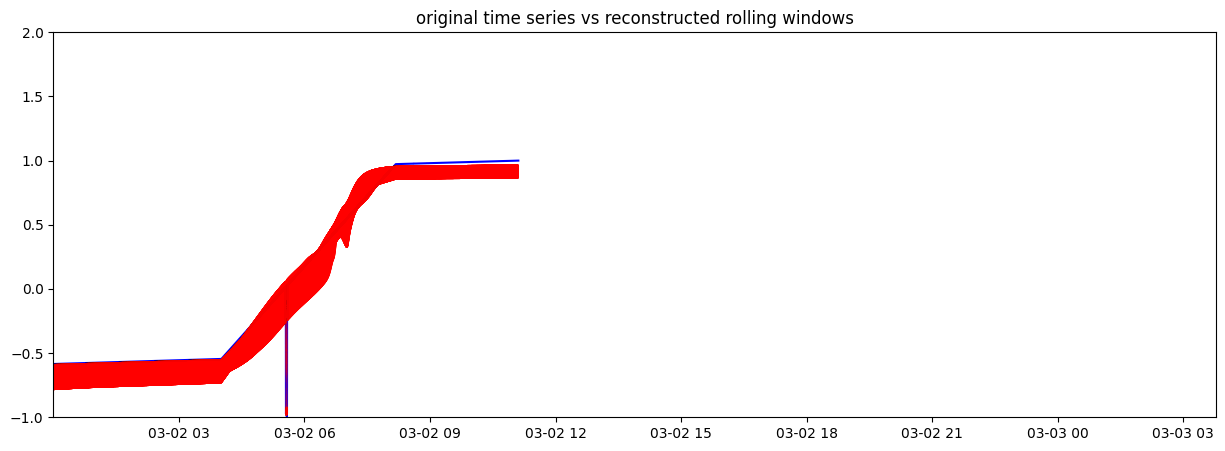

<ipython-input-32-98a4140d22f8>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


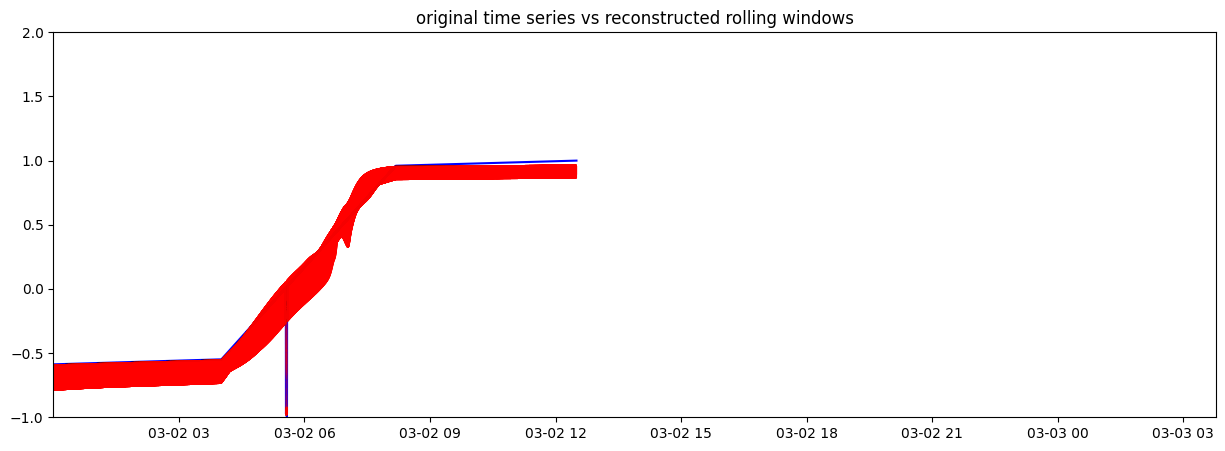

<ipython-input-32-98a4140d22f8>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


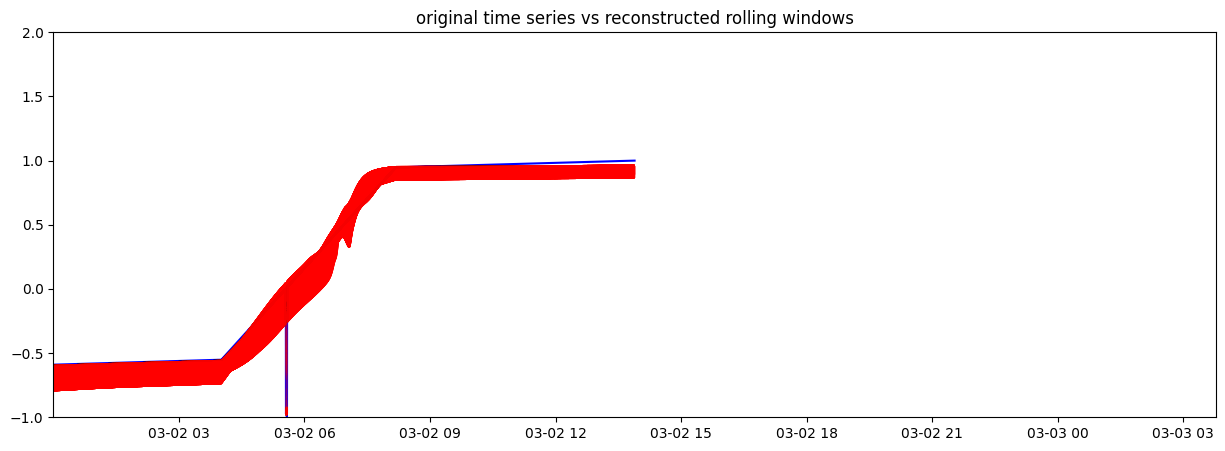

<ipython-input-32-98a4140d22f8>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


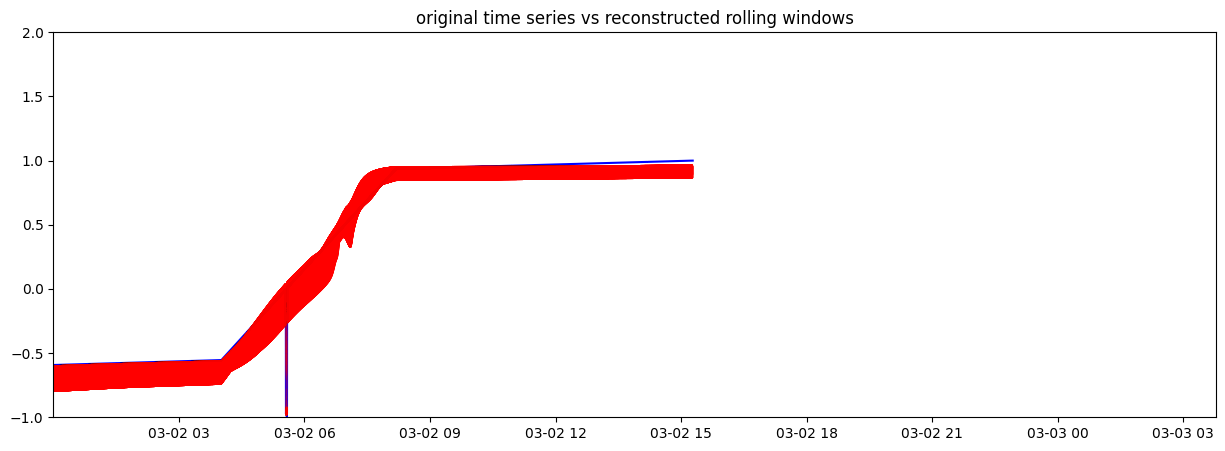

<ipython-input-32-98a4140d22f8>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


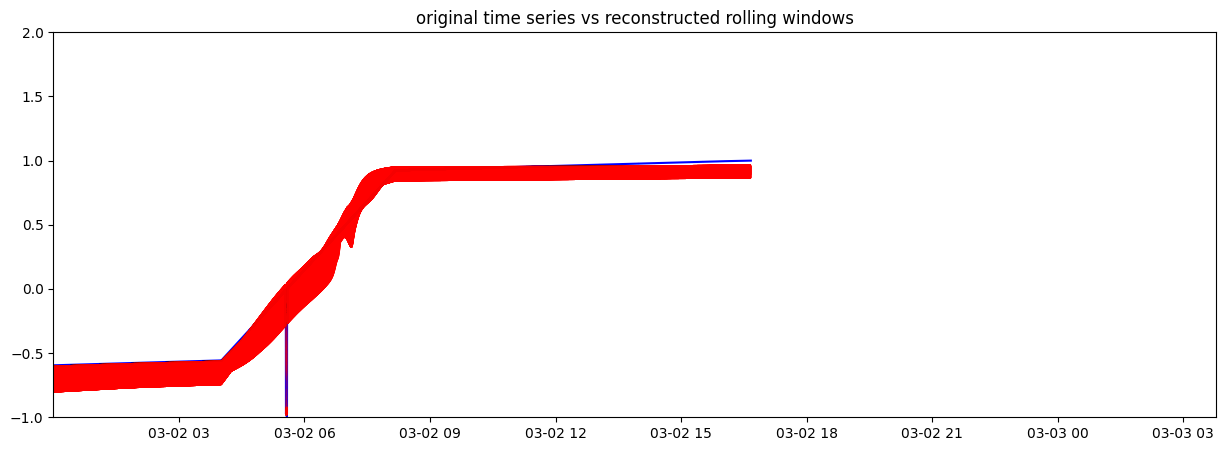

<ipython-input-32-98a4140d22f8>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


InternalError: ignored

In [32]:
# Classifying sensor to be attacked, using histogram comparison
# Reconstruct each time step window of 25 steps for unattacked sensor1 and attacked sensor1

j = 5000
sensor = 'sensor1'
reconstructed = pd.DataFrame()

for i in range(25, len(df)):
  timestep = df[i:i+1]

  old_stdout = sys.stdout # backup current stdout
  sys.stdout = open(os.devnull, "w")
  label_attack = get_difference_and_remove_margin_value(np.array(df[20000:20000+1]).flatten(), percentile_level = 0.95)[1]
  label_attack_95 = list(map(lambda l : l + 1, label_attack))

  label_attack = find_attacked_sensor(np.array(df[1:2]).flatten(), np.array(df[20000:20000+1]).flatten(), np.array(df[1:2]).flatten()[0], mean=0, std=0.1, sample_size1=7, sample_size2=7, percentile_level=0.95)[2]
  label_attack = label_attack + label_attack_95
  sys.stdout = old_stdout # reset old stdout


  updated = []
  for k in range(0,len(np.array(df[i:i+1]).flatten())):
    if k not in label_attack:
      updated = updated + [np.nan]
    else:
      updated = updated + [np.array(df[i:i+1]).flatten()[k]]

  # Replacing attacked sensor values with Nan

  df.loc[i] = updated

  # Imputing Nan with SAITs
  if i % 100 == 0 :
    X = df[i-100:i].to_numpy()

    X = X[:1 * 100, :].reshape(1, 100, 7)

    # X_intact, X, missing_mask, indicating_mask = mcar(X, 0.1) # hold out 10% observed values as ground truth
    # X = masked_fill(X, 1 - missing_mask, np.nan)

    dataset = {"X": X}
    imputation = saits.impute(dataset)

    df[i-100:i] = pd.DataFrame(imputation.reshape(-1, X.shape[-1]))



  if i == j:
    path1_train = df
    path1_sensor1_train = pd.DataFrame(path1_train[sensor])

    path1_sensor1_train['timestamp'] = pd.to_datetime('2023-03-02')
    path1_sensor1_train['index'] = range(1, len(path1_sensor1_train) + 1)
    path1_sensor1_train['timestamp'] = path1_sensor1_train['timestamp'] + pd.to_timedelta(path1_sensor1_train['index'], unit='s')
    path1x1 = path1_sensor1_train[['timestamp', sensor]]

    path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))

    path1x1 = path1x1.set_index('timestamp')[sensor]


    path1x1 = path1x1.astype(np.float64)

    x= path1x1[:i]
    x, t, x_win, t_win = pre_proc_apply_pipeline(x=x, freq=RESAMPLE_FREQ, window_size=WINDOW_SIZE)

    x_win_recon, critic_scores = model.predict(x_win)
    # reconstructed = pd.concat([reconstructed, pd.DataFrame(x_win_recon[1:].flatten())], axis = 1)
    plot_time_series(t, x, x_win=x_win_recon,
                       date_range=['2023-03-02 00:00:01', '2023-03-03 03:46:40'], value_range=[-1, 2],
                       title='original time series vs reconstructed rolling windows')
    j = j + 5000



<function matplotlib.pyplot.show(close=None, block=None)>

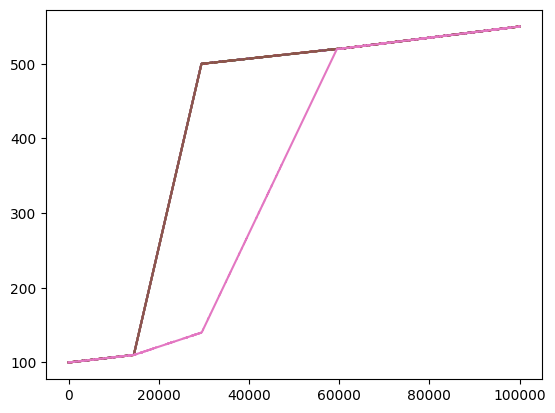

In [58]:
df_org_copy = pd.concat([df1, df2], axis=1)
df_org_copy = df_org_copy.drop(df_org_copy.columns[[0, 2, 3, 4, 5]],axis = 1)


plt.plot(range(len(df_org_copy['protected_sensor'])), df_org_copy['protected_sensor'])
plt.plot(range(len(df_org_copy['sensor1'])), df_org_copy['sensor1'])
plt.plot(range(len(df_org_copy['sensor2'])), df_org_copy['sensor2'])
plt.plot(range(len(df_org_copy['sensor3'])), df_org_copy['sensor3'])
plt.plot(range(len(df_org_copy['sensor4'])), df_org_copy['sensor4'])
plt.plot(range(len(df_org_copy['sensor5'])), df_org_copy['sensor5'])
plt.plot(range(len(df_org_copy['sensor2_1'])), df_org_copy['sensor2_1'])

plt.show

<ipython-input-59-c3400c7ea363>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1_attacked['timestamp'] = path1x1_attacked['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


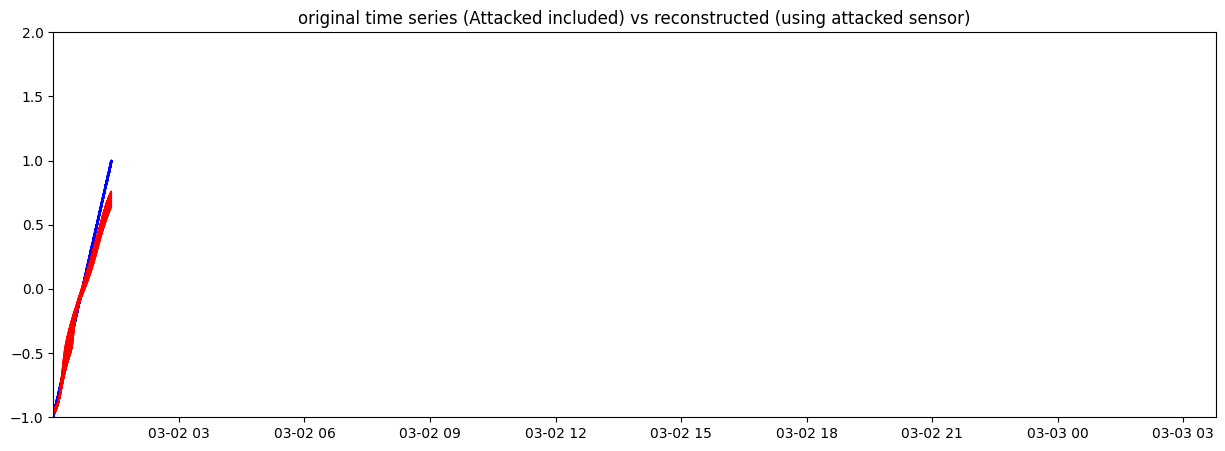

<ipython-input-59-c3400c7ea363>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


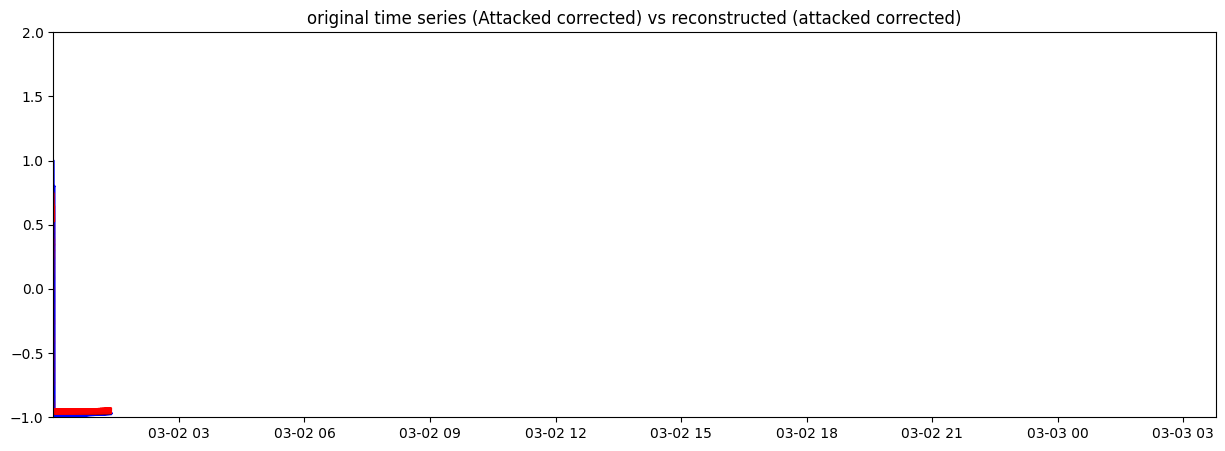

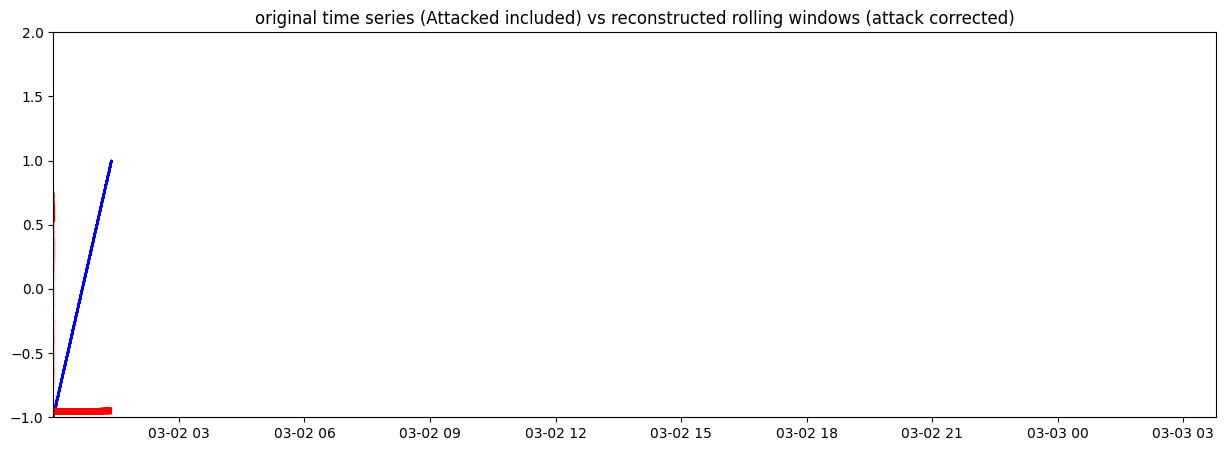

<ipython-input-59-c3400c7ea363>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1_attacked['timestamp'] = path1x1_attacked['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


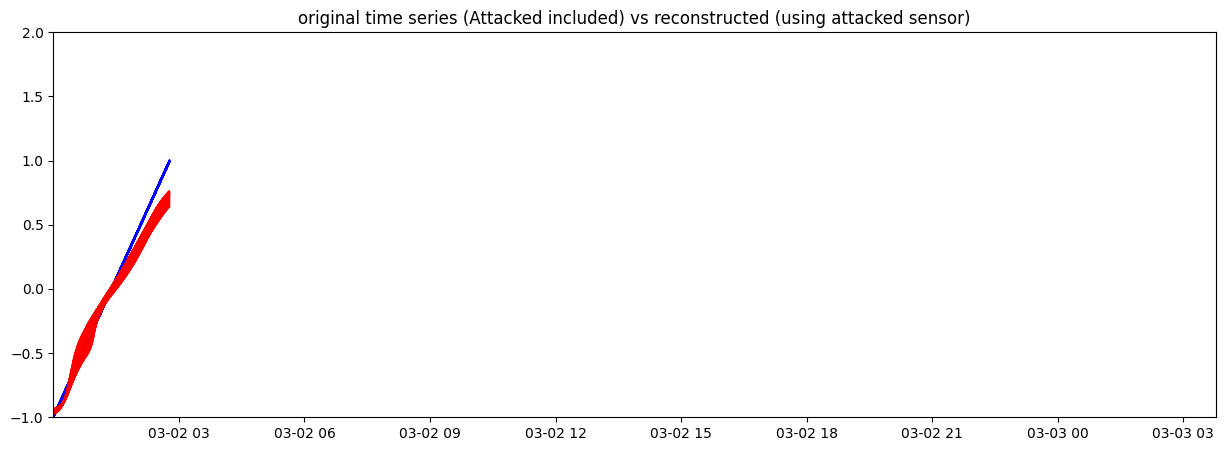

<ipython-input-59-c3400c7ea363>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


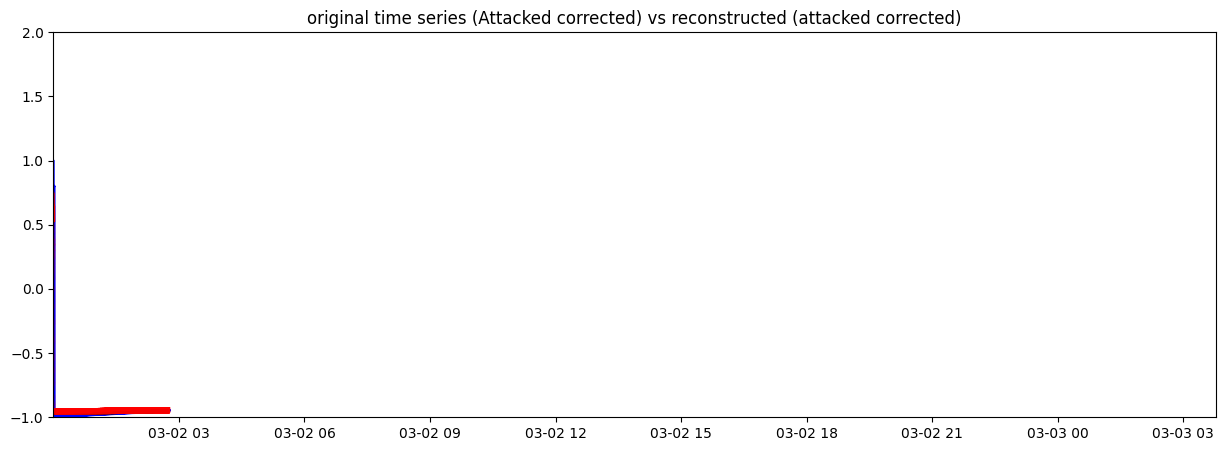

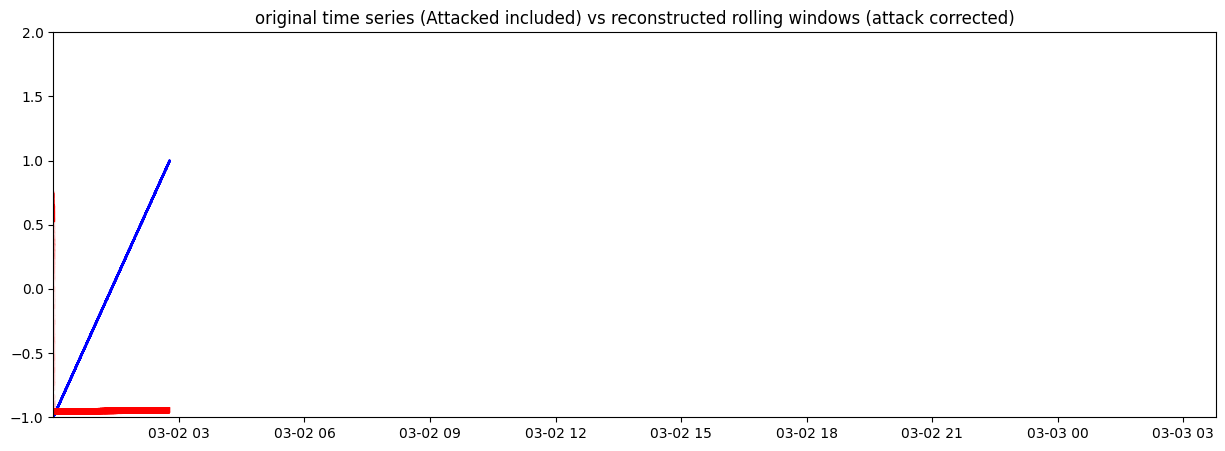

<ipython-input-59-c3400c7ea363>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1_attacked['timestamp'] = path1x1_attacked['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


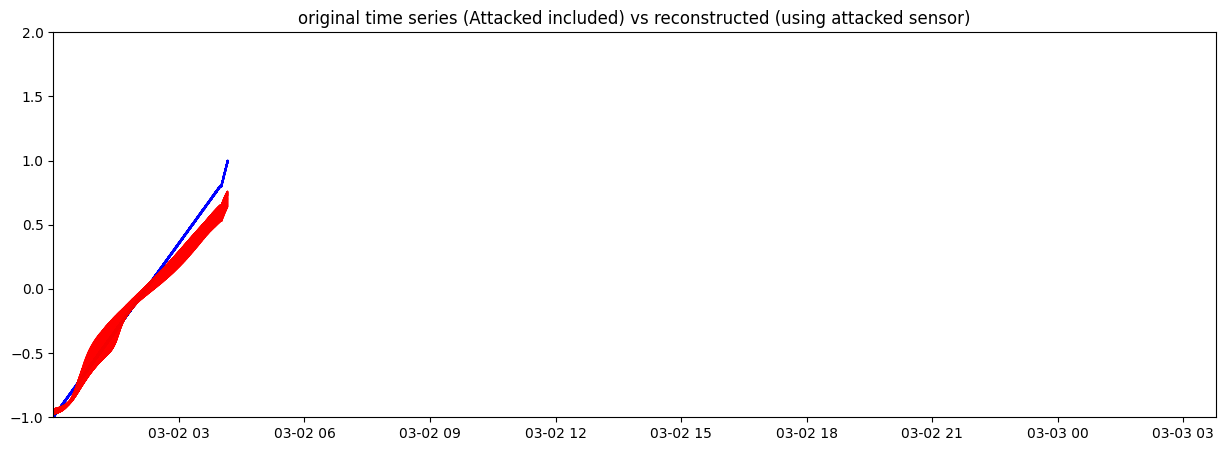

<ipython-input-59-c3400c7ea363>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


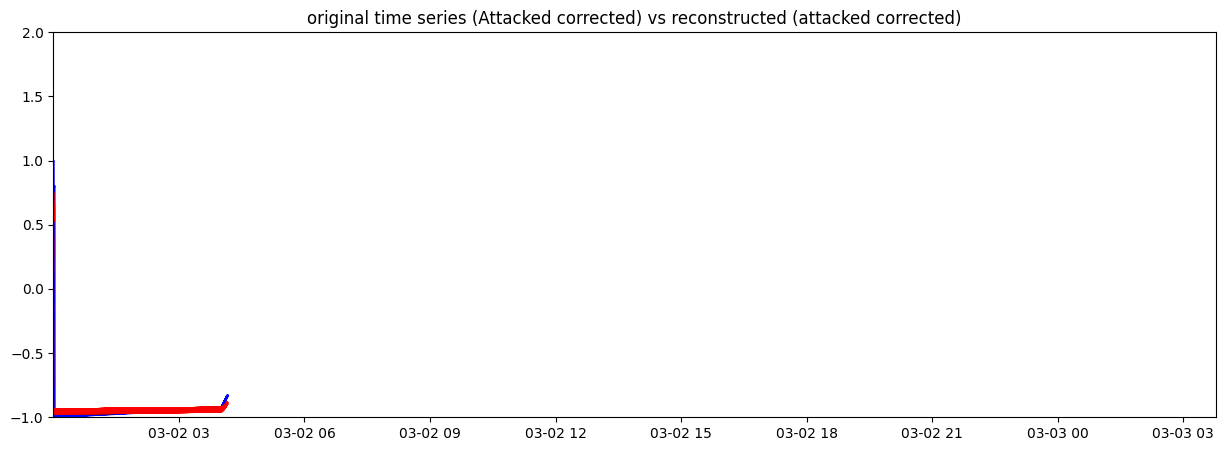

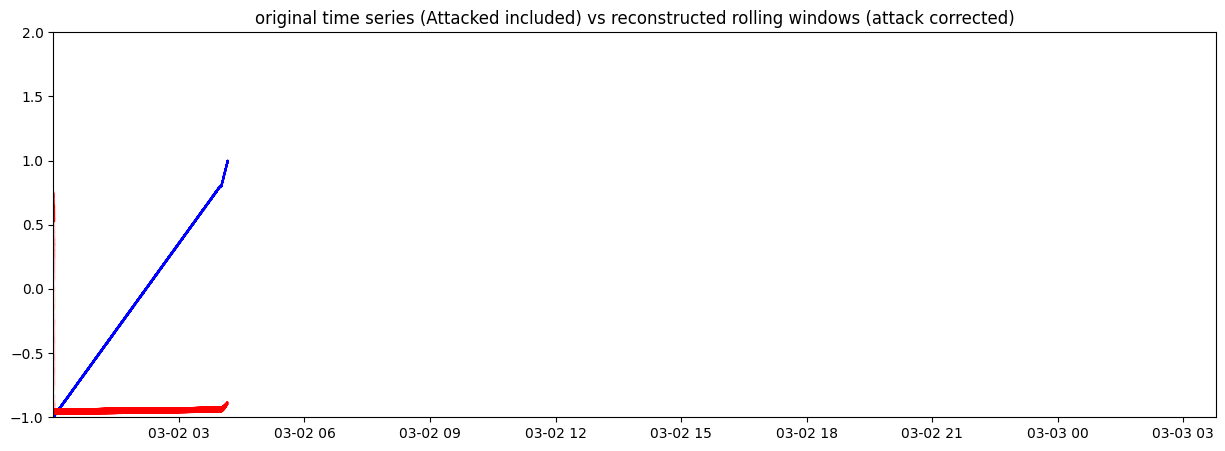

<ipython-input-59-c3400c7ea363>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1_attacked['timestamp'] = path1x1_attacked['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


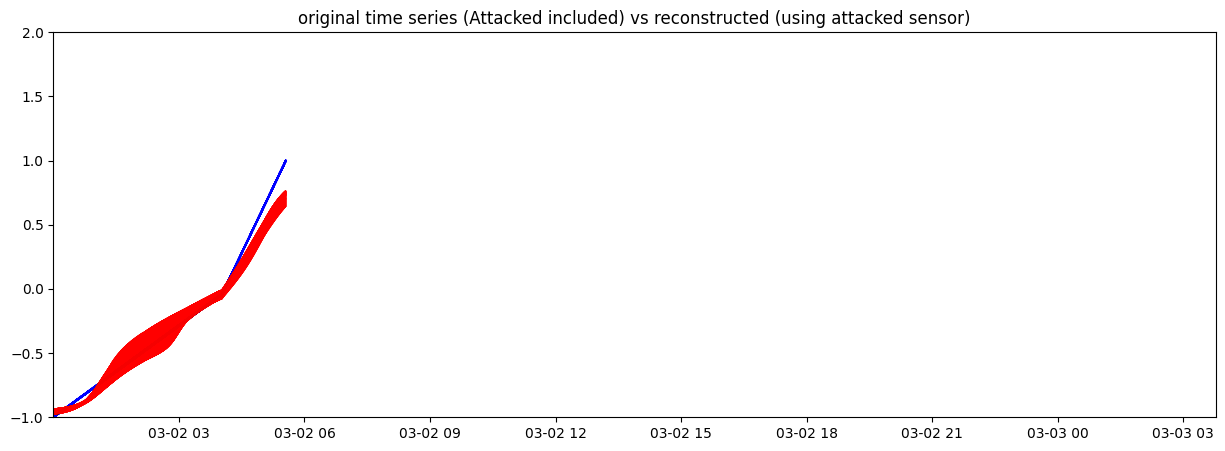

<ipython-input-59-c3400c7ea363>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


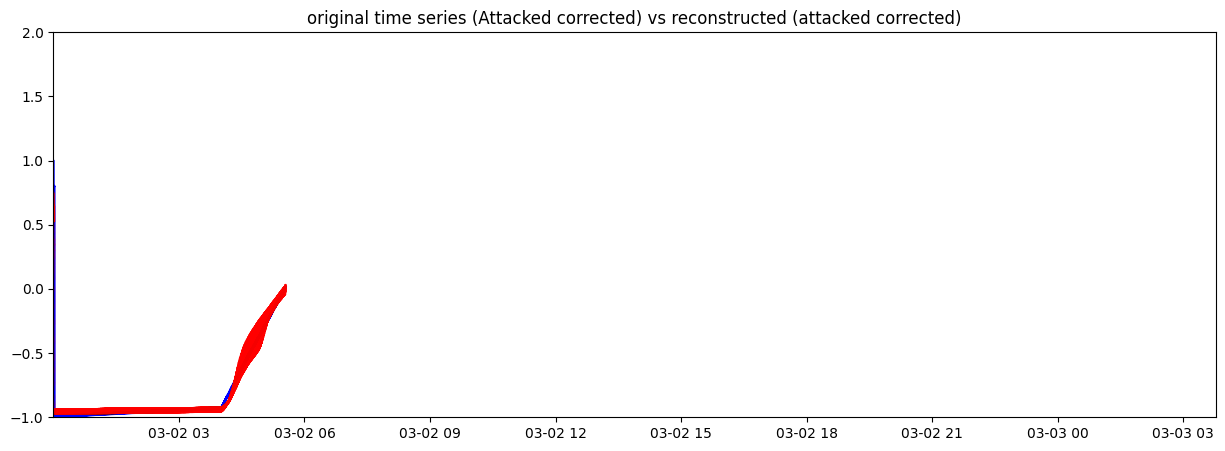

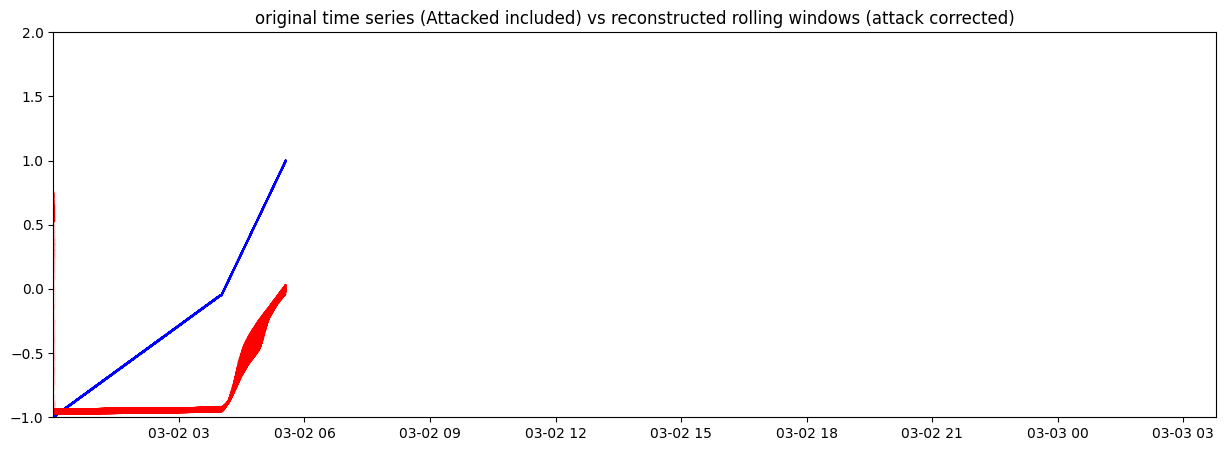

<ipython-input-54-da0013c55cbf>:30: RuntimeWarning: invalid value encountered in true_divide
  counts4=(counts2/len(testing))*1000
<ipython-input-59-c3400c7ea363>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1_attacked['timestamp'] = path1x1_attacked['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


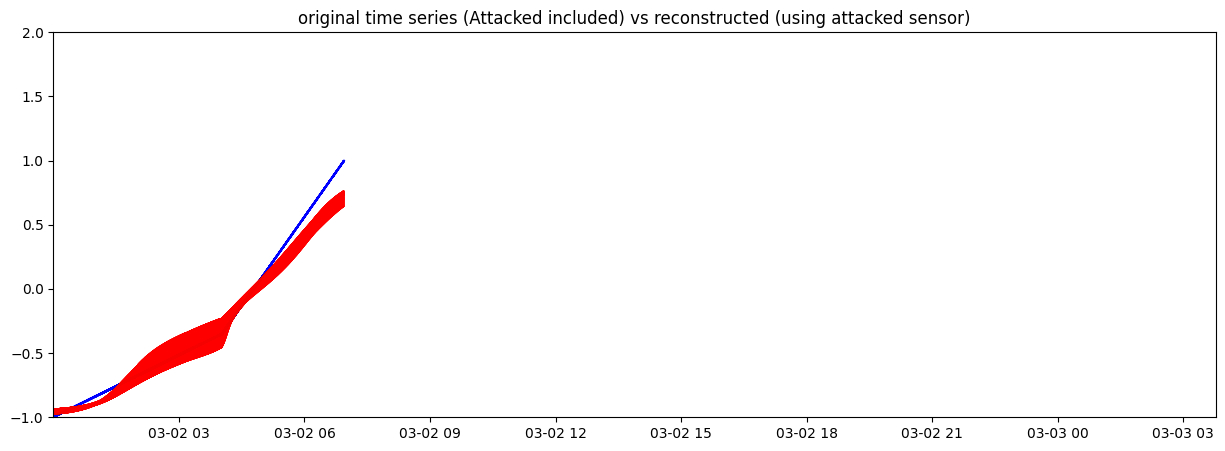

<ipython-input-59-c3400c7ea363>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


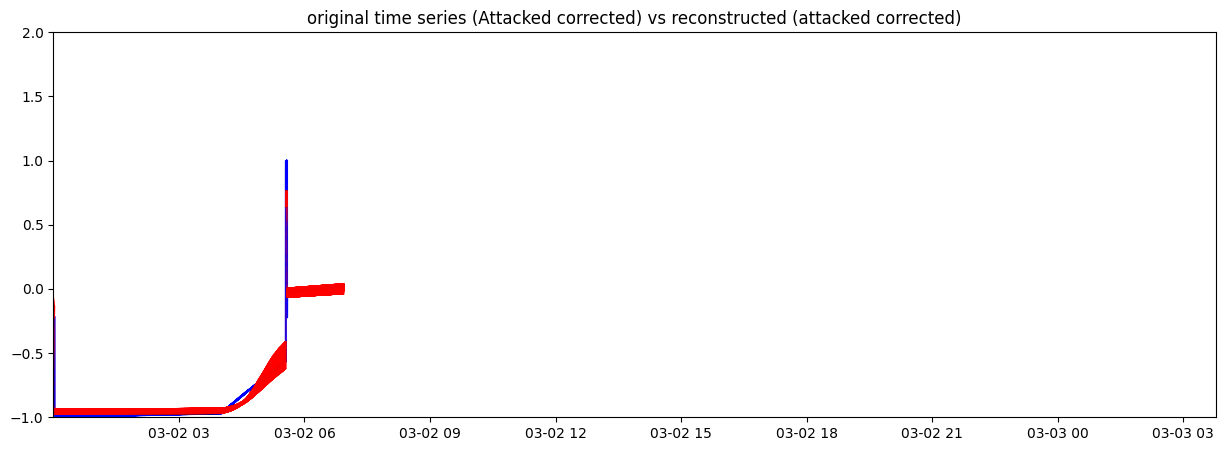

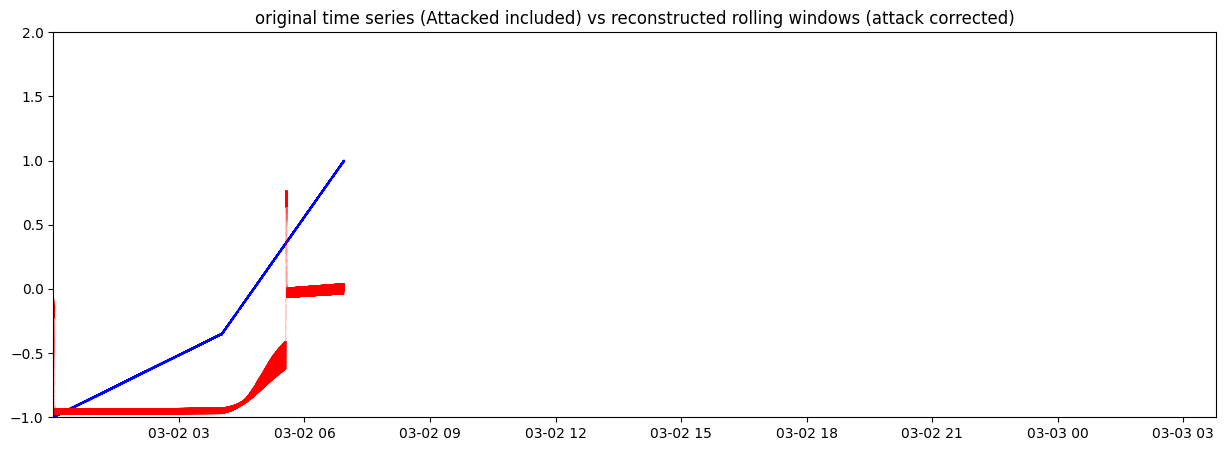

<ipython-input-59-c3400c7ea363>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1_attacked['timestamp'] = path1x1_attacked['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


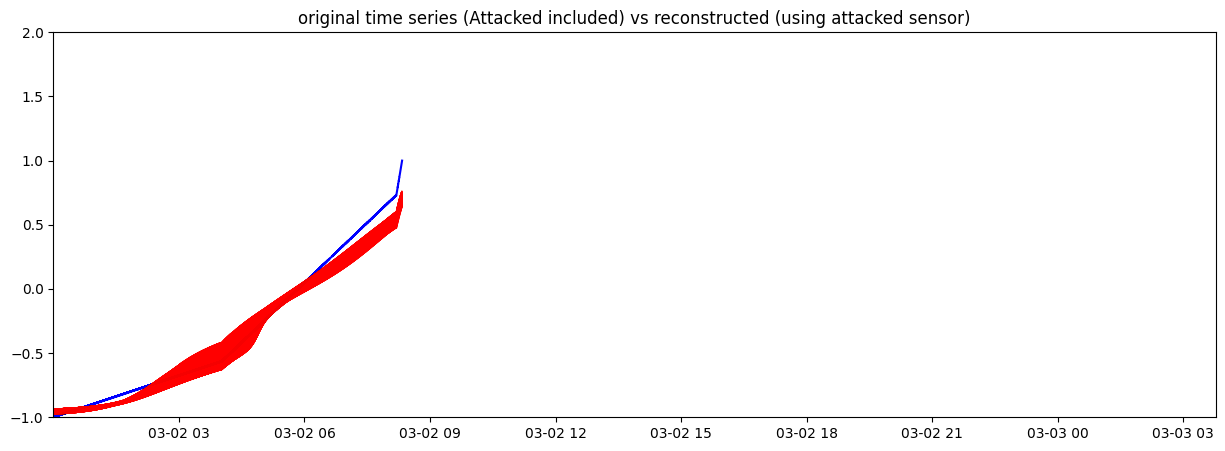

<ipython-input-59-c3400c7ea363>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


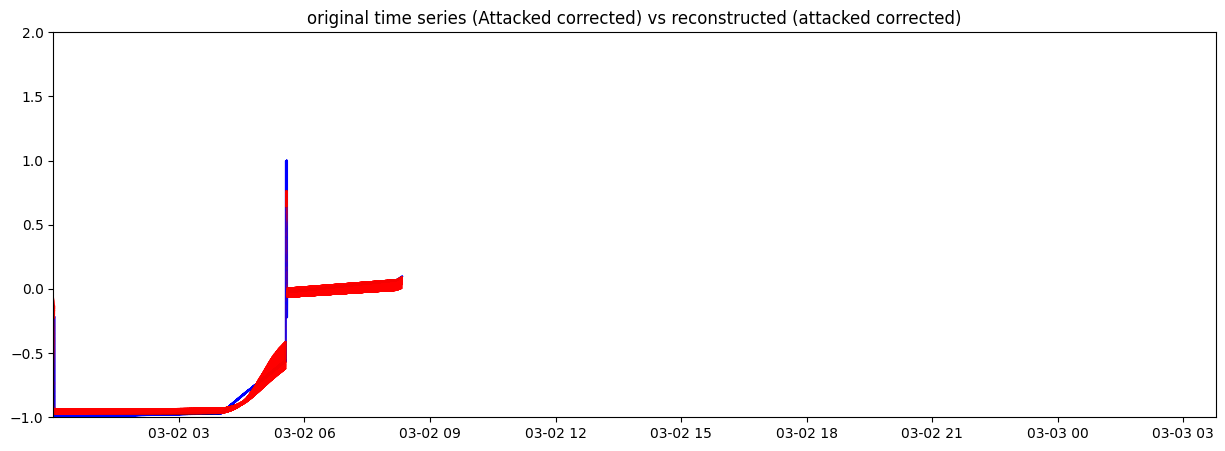

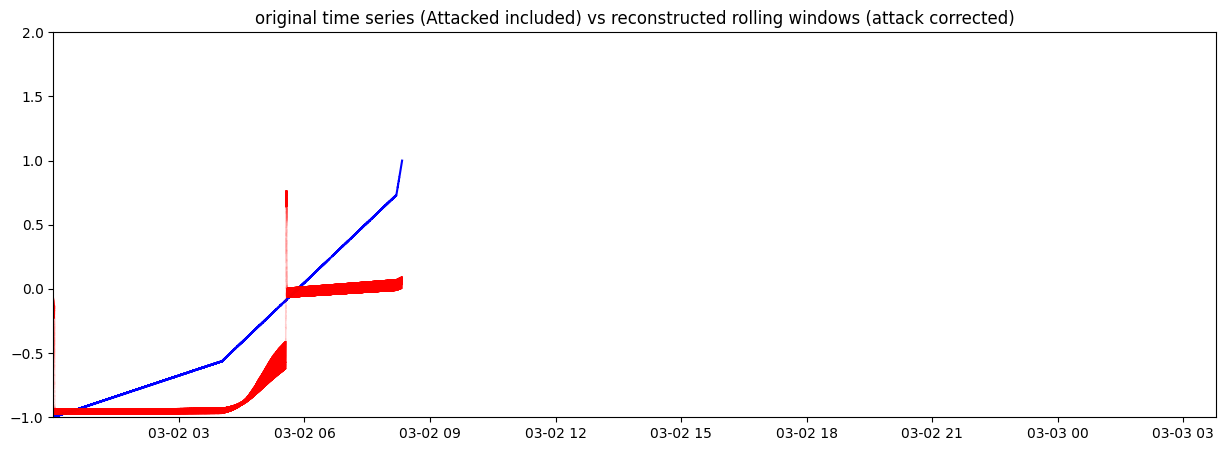

<ipython-input-59-c3400c7ea363>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1_attacked['timestamp'] = path1x1_attacked['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


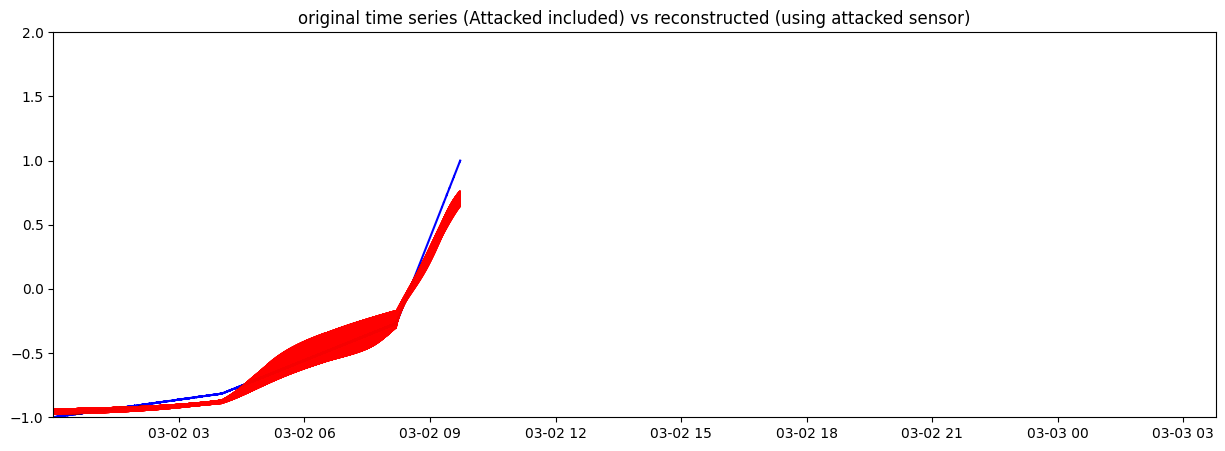

<ipython-input-59-c3400c7ea363>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


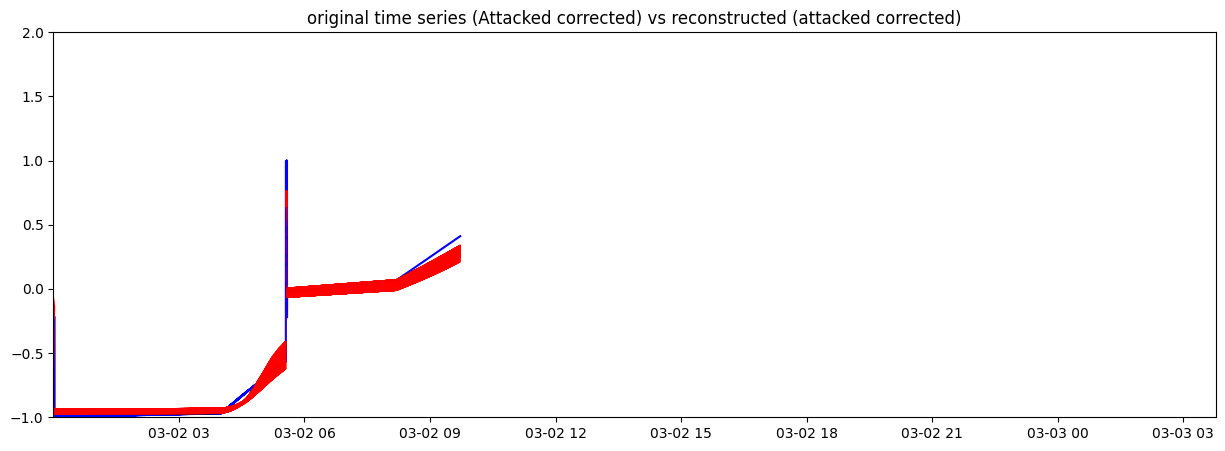

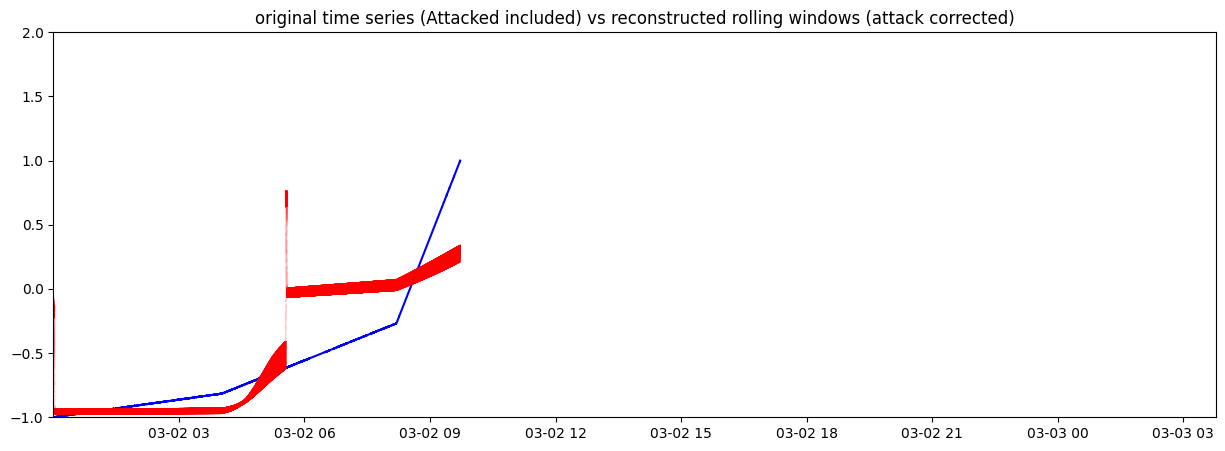

<ipython-input-59-c3400c7ea363>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1_attacked['timestamp'] = path1x1_attacked['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


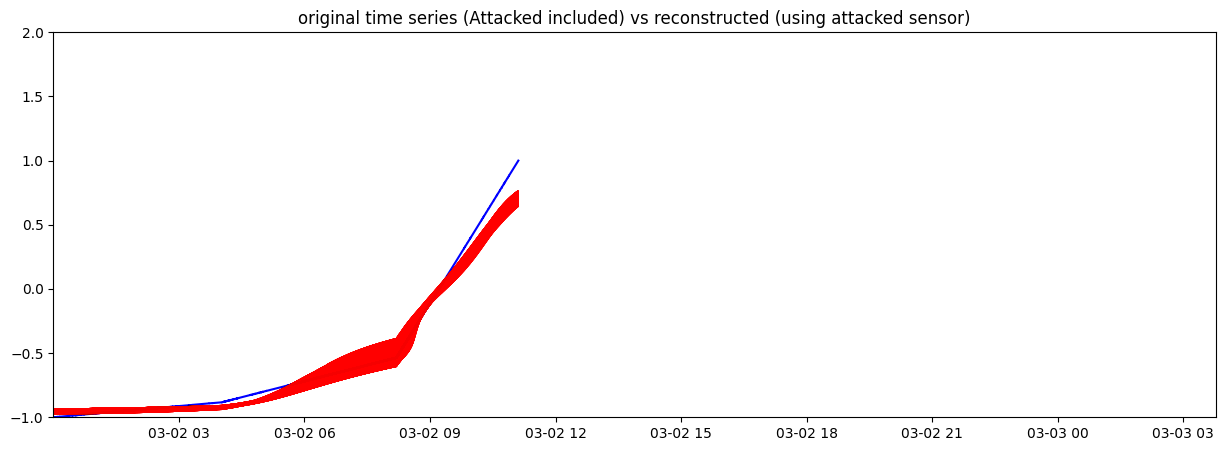

<ipython-input-59-c3400c7ea363>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


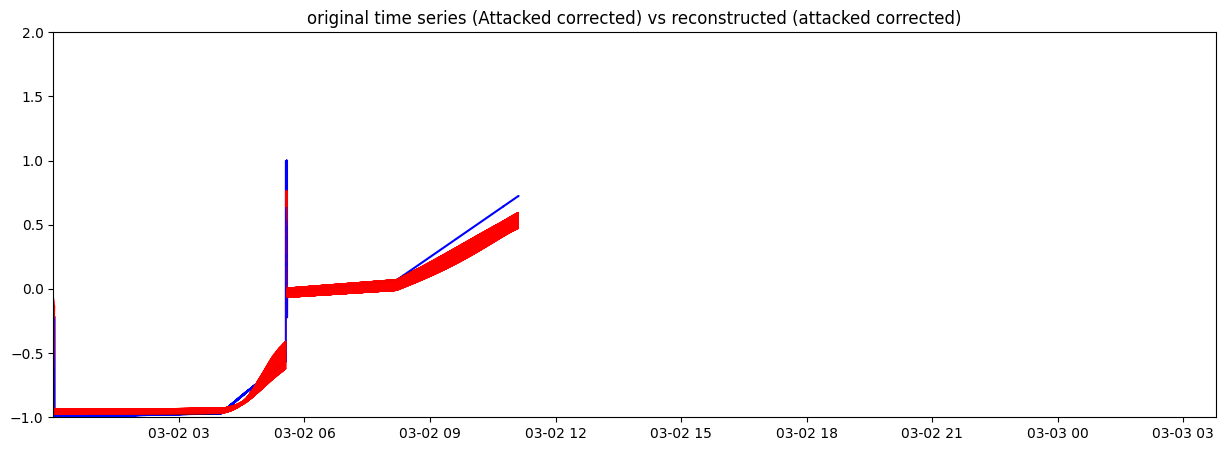

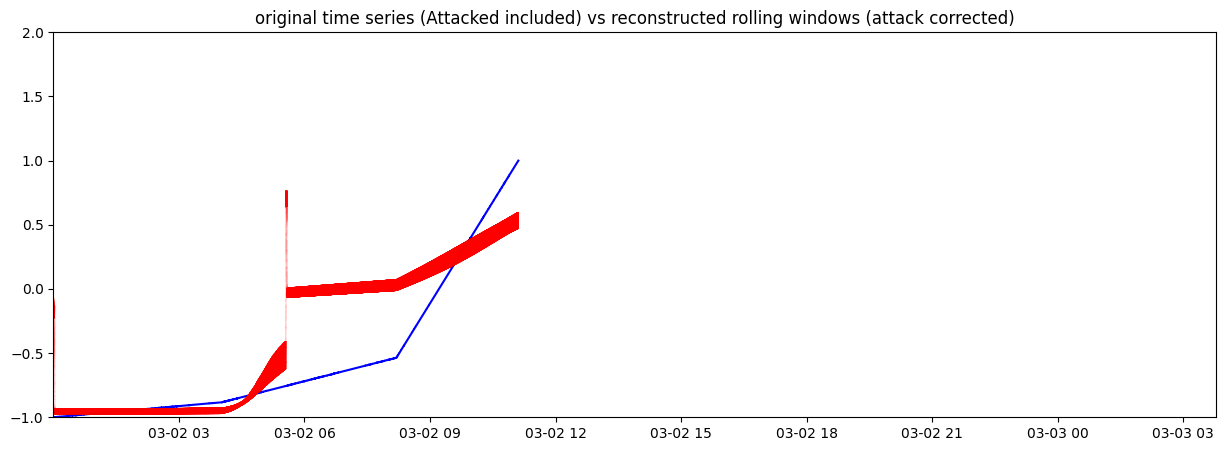

<ipython-input-59-c3400c7ea363>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1_attacked['timestamp'] = path1x1_attacked['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


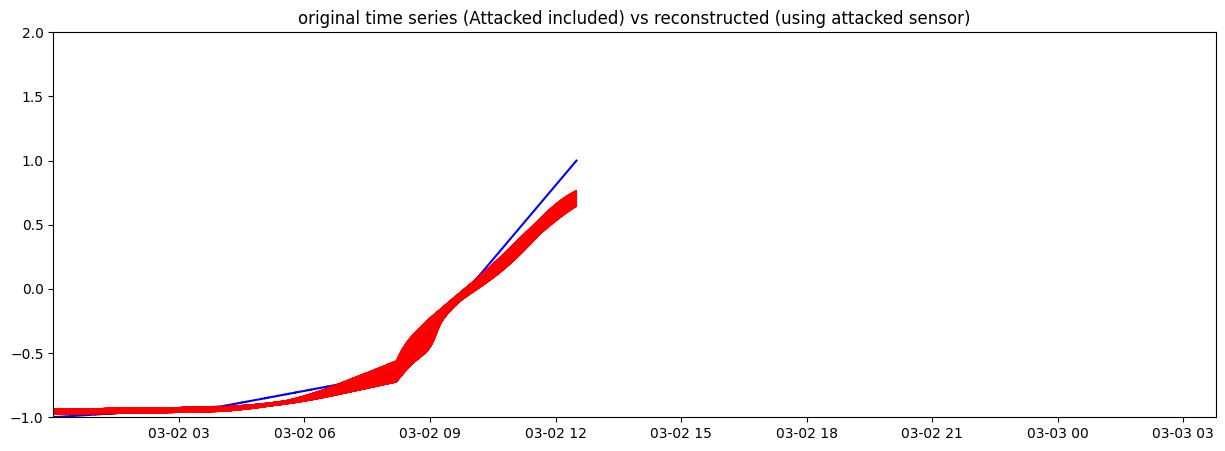

<ipython-input-59-c3400c7ea363>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


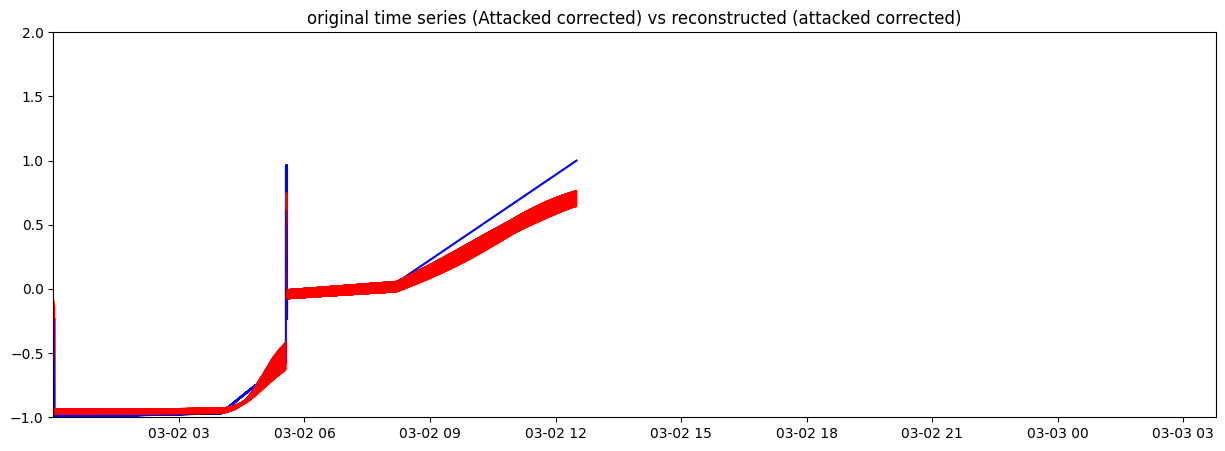

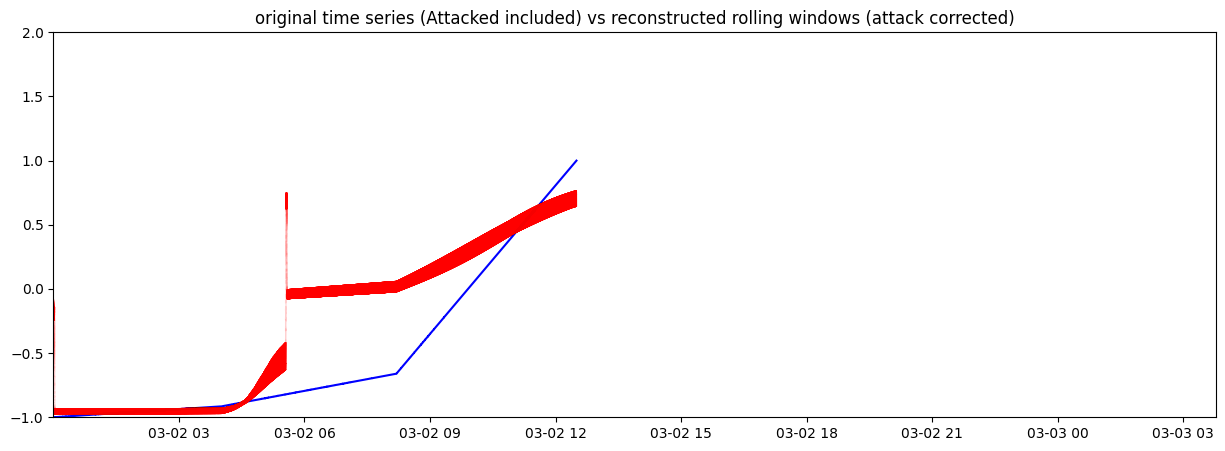

<ipython-input-59-c3400c7ea363>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1_attacked['timestamp'] = path1x1_attacked['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


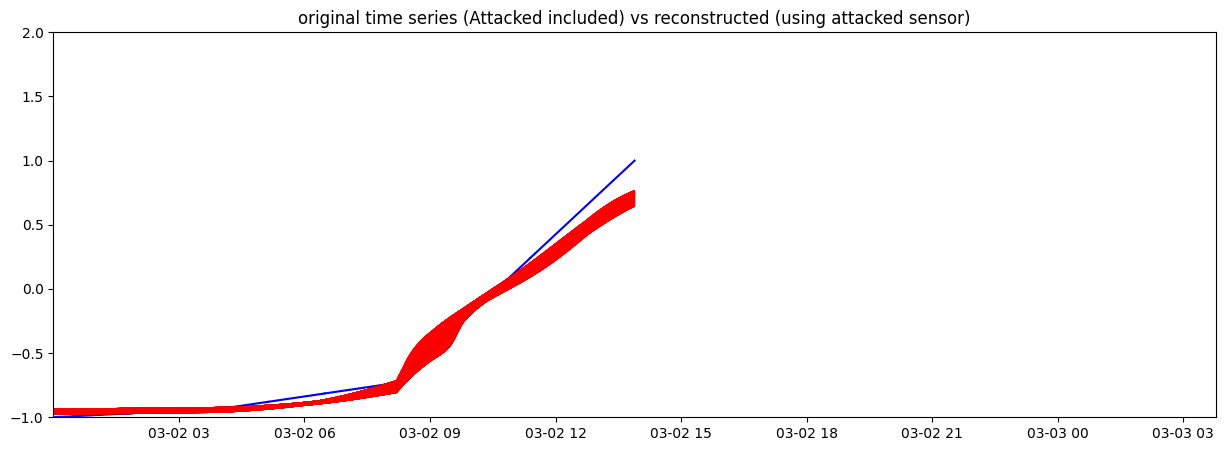

<ipython-input-59-c3400c7ea363>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


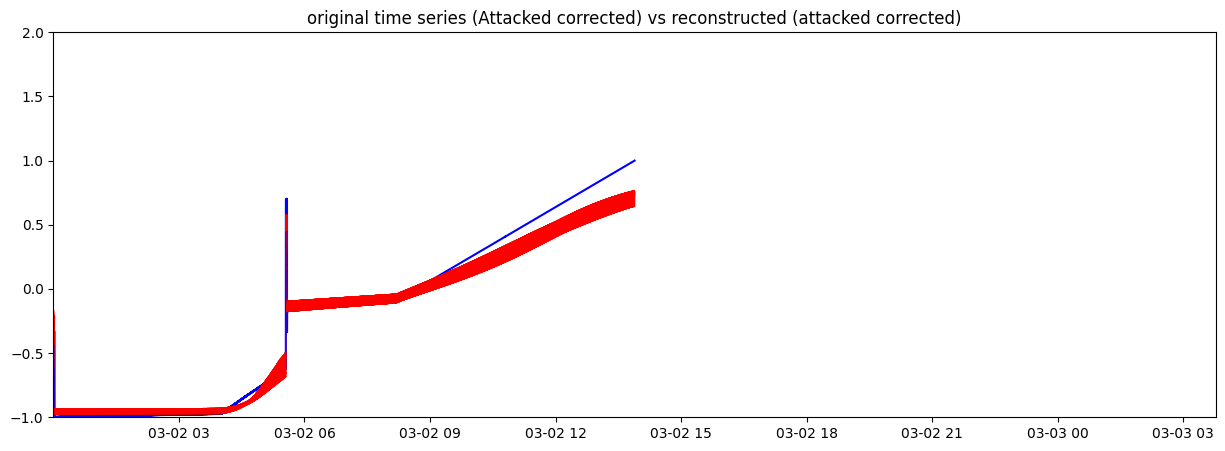

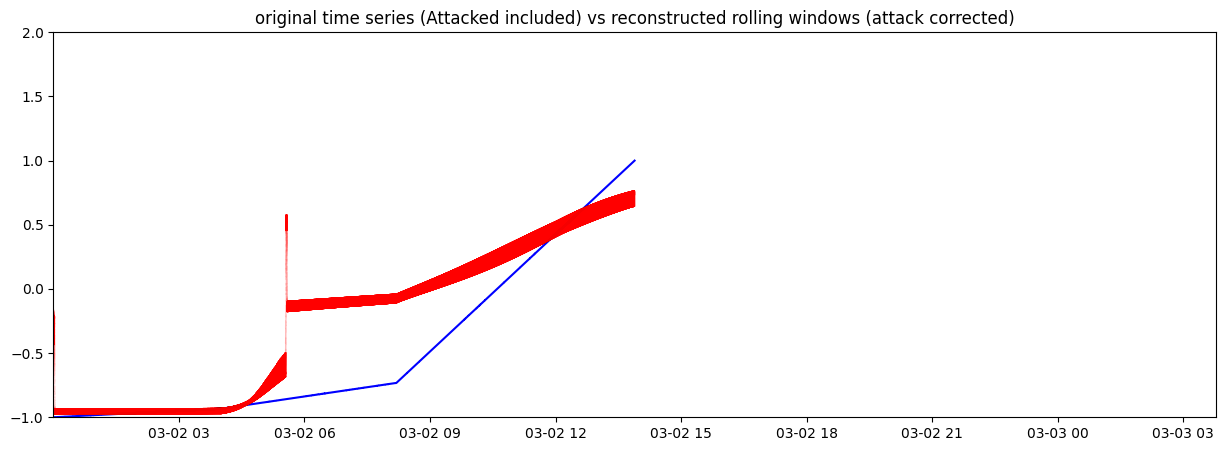

<ipython-input-59-c3400c7ea363>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1_attacked['timestamp'] = path1x1_attacked['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


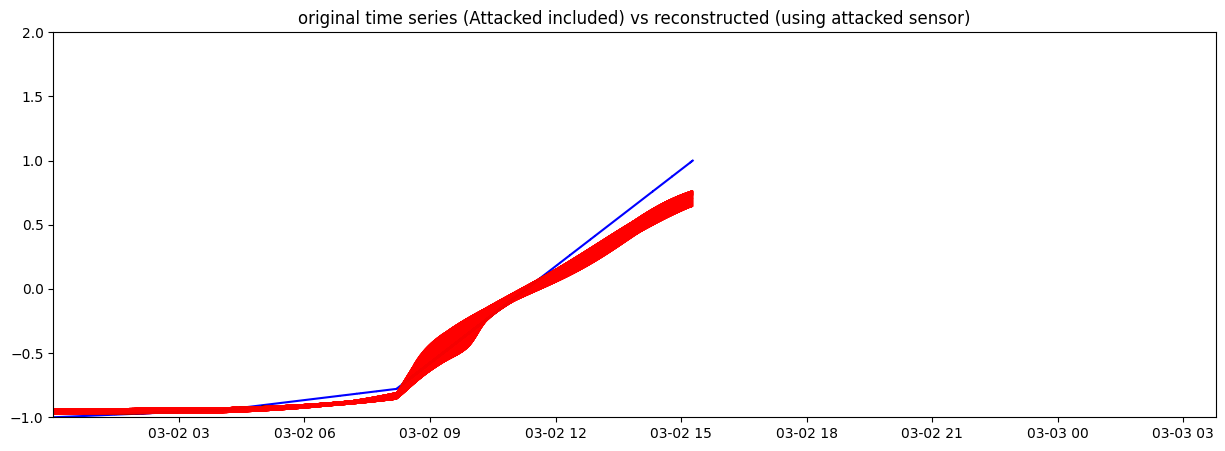

<ipython-input-59-c3400c7ea363>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


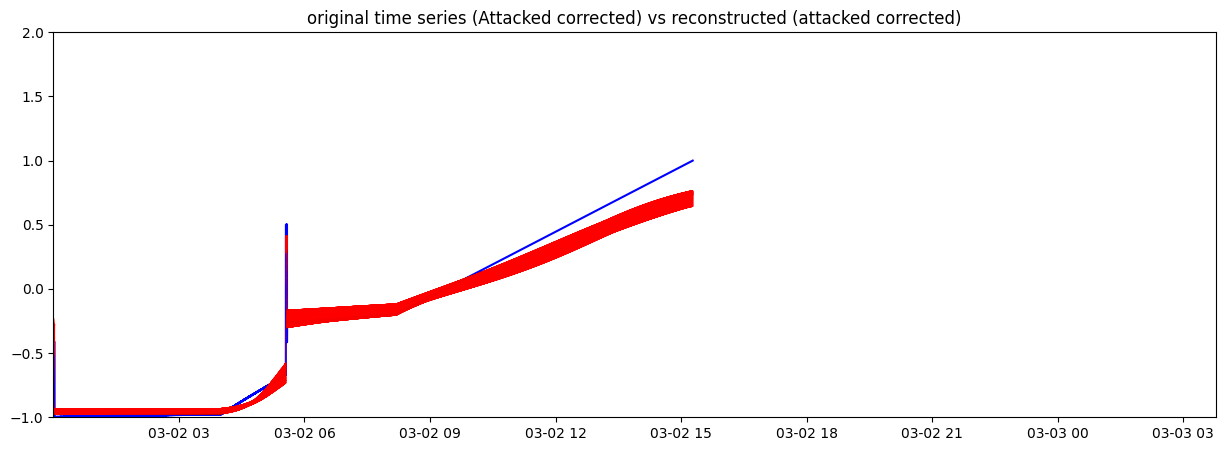

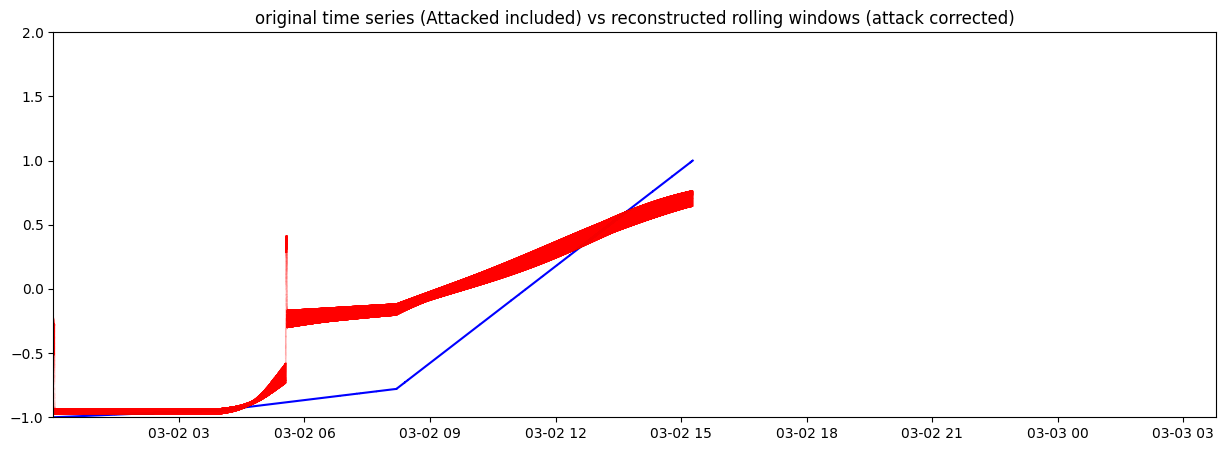

<ipython-input-59-c3400c7ea363>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1_attacked['timestamp'] = path1x1_attacked['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


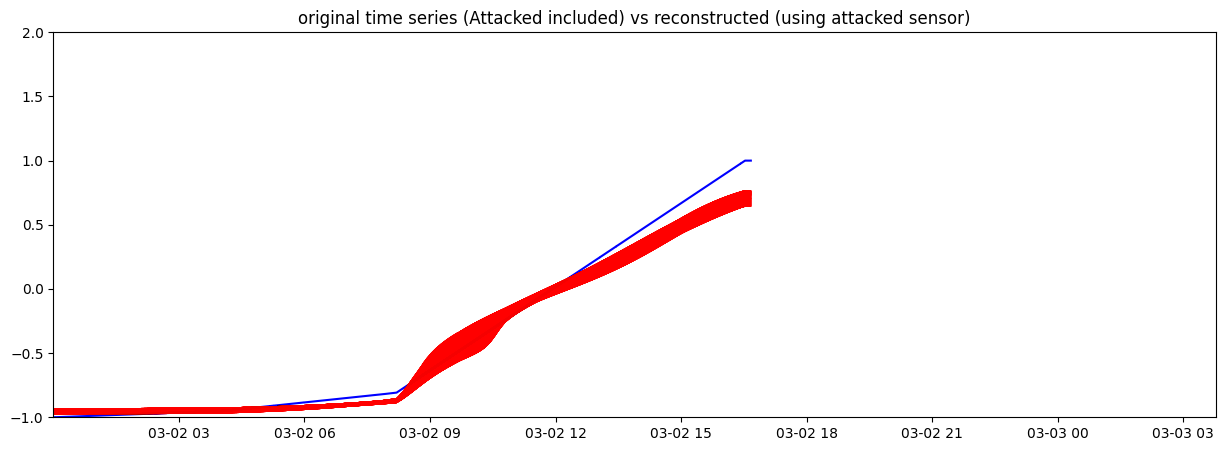

<ipython-input-59-c3400c7ea363>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


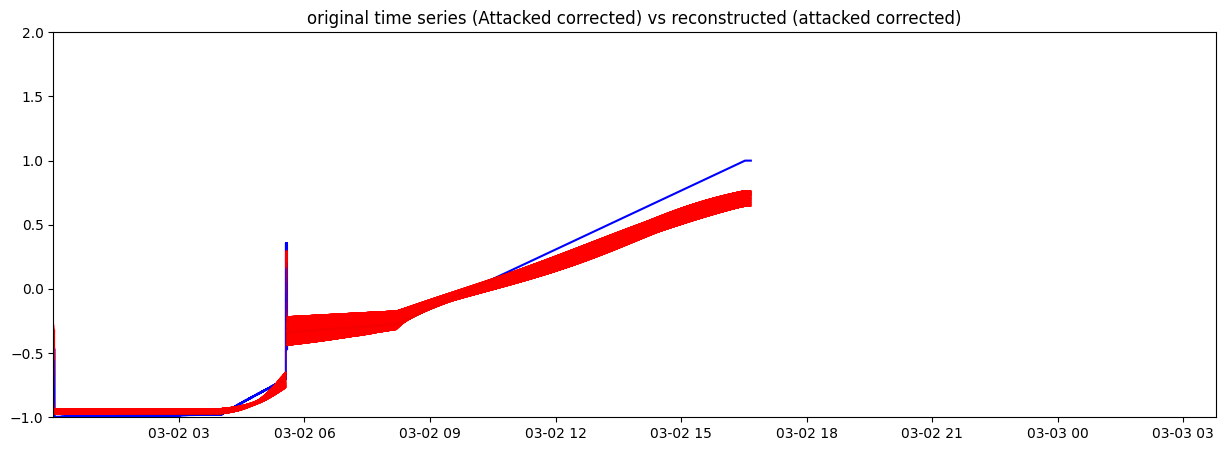

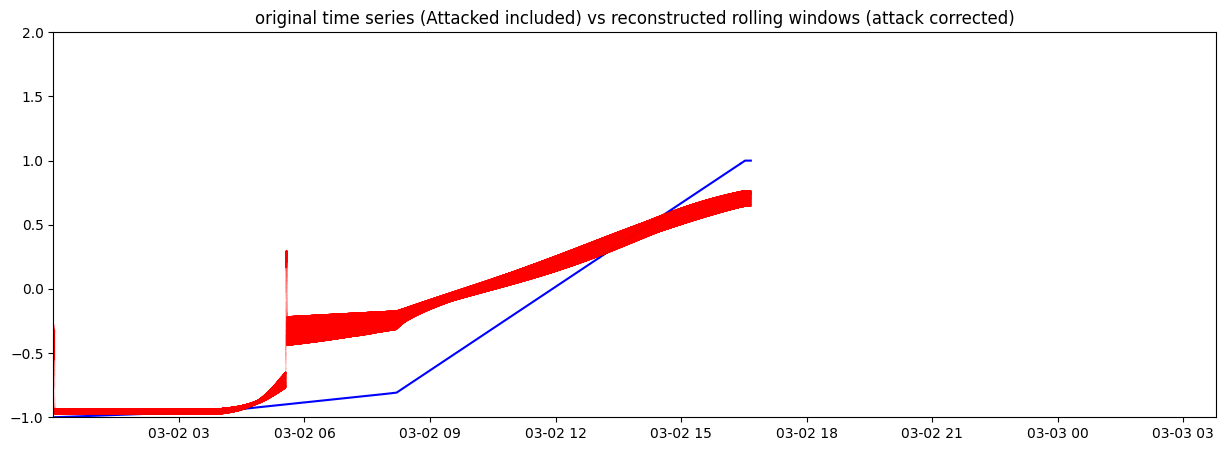

<ipython-input-59-c3400c7ea363>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1_attacked['timestamp'] = path1x1_attacked['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


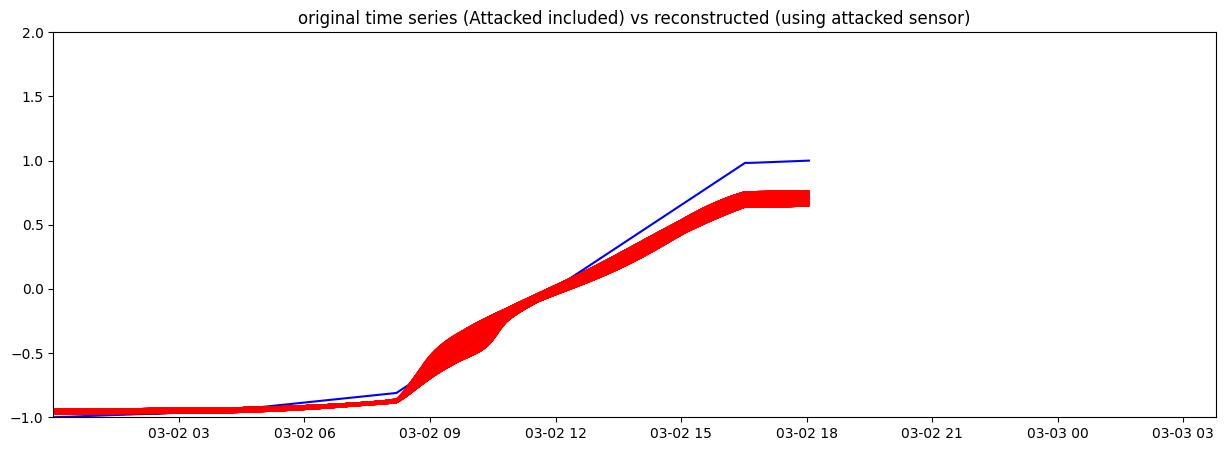

<ipython-input-59-c3400c7ea363>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


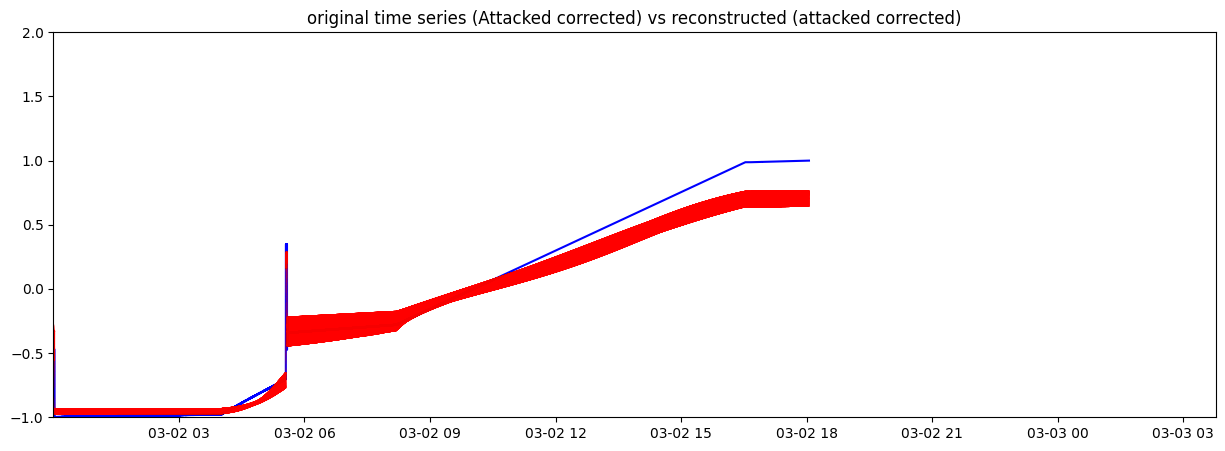

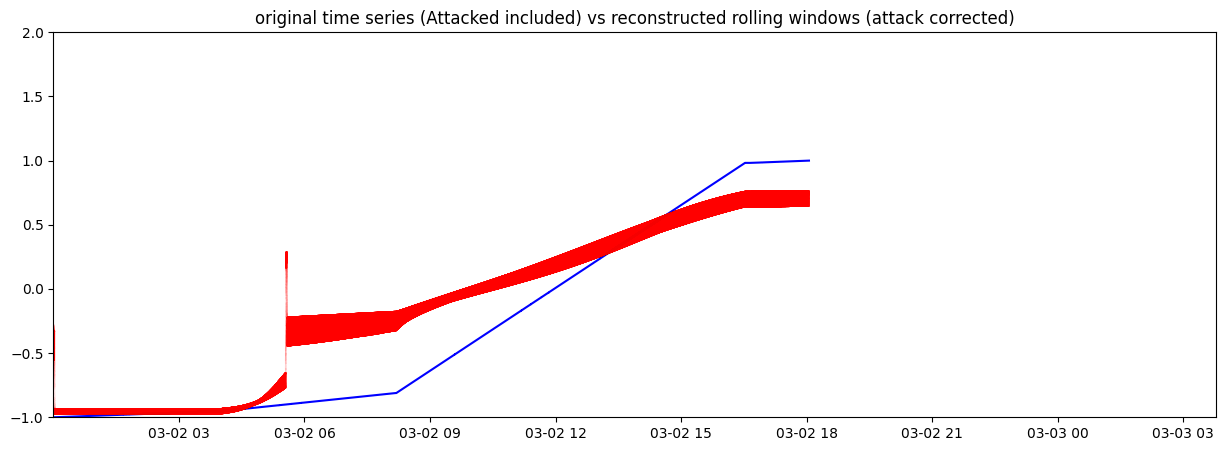

<ipython-input-59-c3400c7ea363>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1_attacked['timestamp'] = path1x1_attacked['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


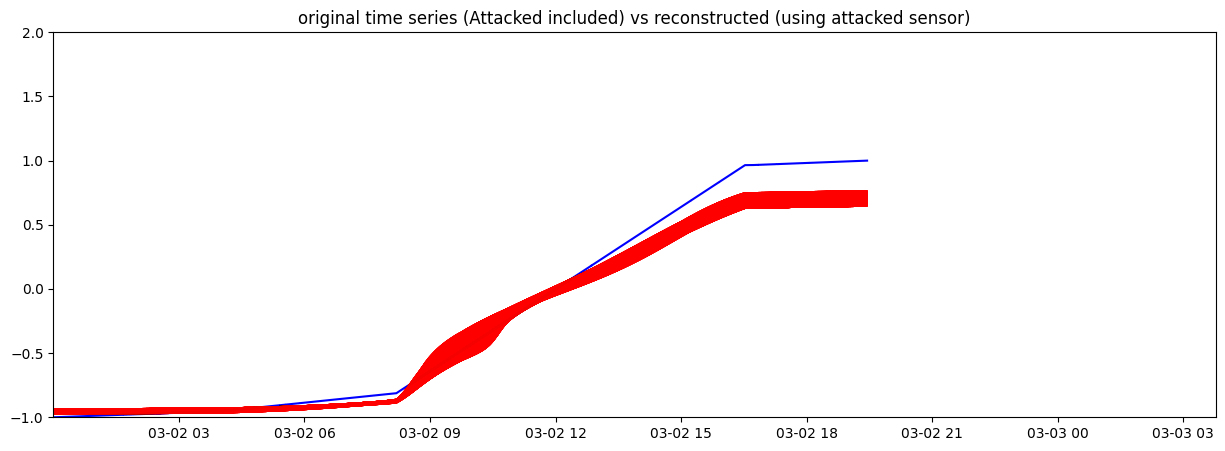

<ipython-input-59-c3400c7ea363>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


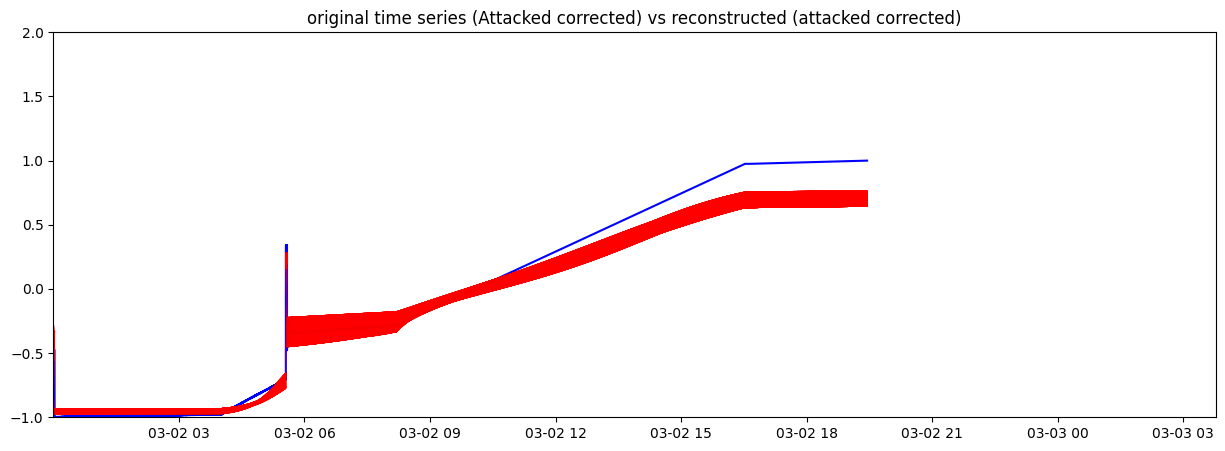

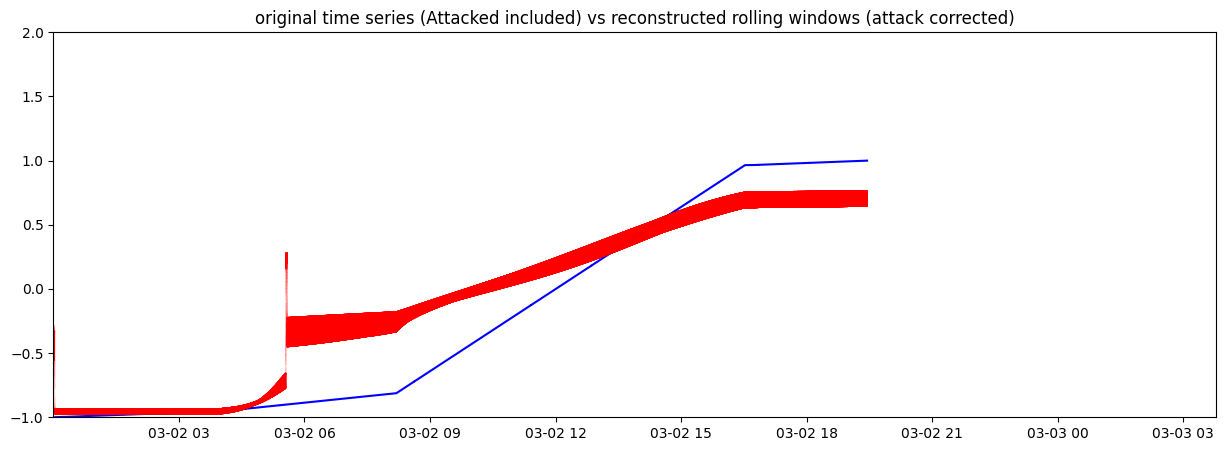

<ipython-input-59-c3400c7ea363>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1_attacked['timestamp'] = path1x1_attacked['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


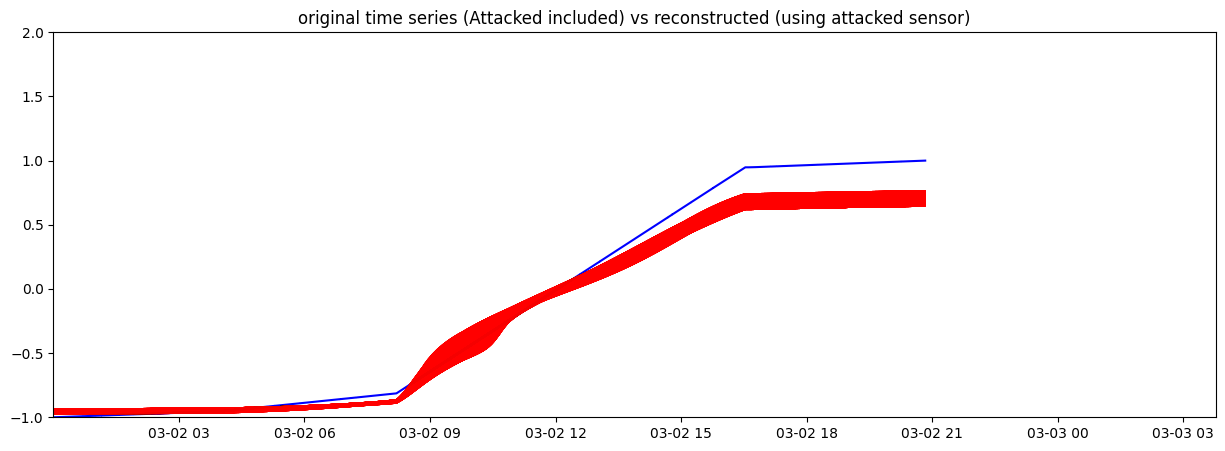

<ipython-input-59-c3400c7ea363>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


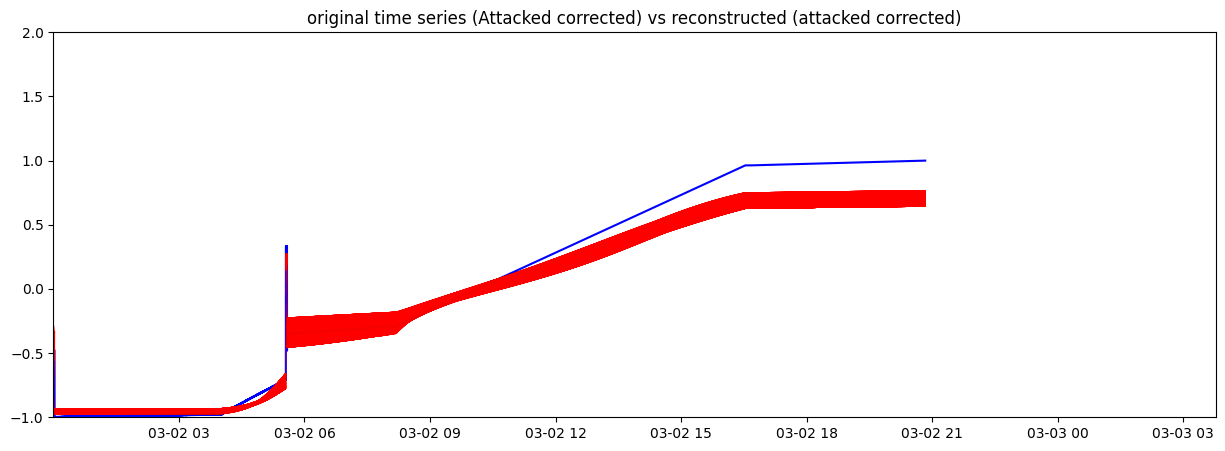

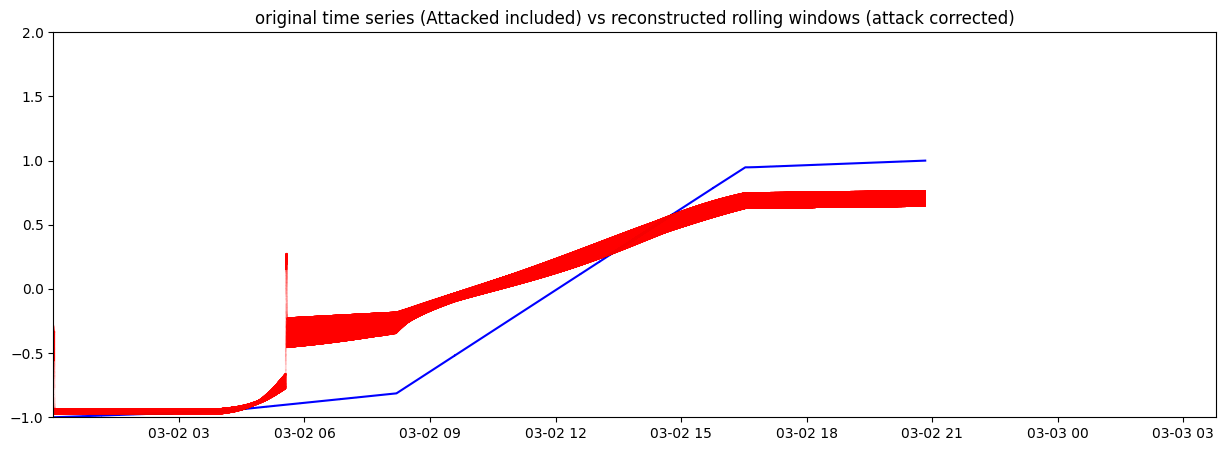

<ipython-input-59-c3400c7ea363>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path1x1_attacked['timestamp'] = path1x1_attacked['timestamp'].map(lambda ts: np.datetime64(ts, 's'))


In [ ]:
# Classifying sensor to be attacked, using histogram comparison
# Reconstruct each time step window of 25 steps for unattacked sensor1 and attacked sensor1

# org_seq = df[:25]
j = 5000
sensor = 'sensor2_1'
reconstructed = pd.DataFrame()

for i in range(25, len(df)):


  timestep = df[i:i+1]

  old_stdout = sys.stdout # backup current stdout
  sys.stdout = open(os.devnull, "w")
  label_attack = get_difference_and_remove_margin_value(np.array(df[20000:20000+1]).flatten(), percentile_level = 0.95)[1]
  label_attack_95 = list(map(lambda l : l + 1, label_attack))

  label_attack = find_attacked_sensor(np.array(df[1:2]).flatten(), np.array(df[20000:20000+1]).flatten(), np.array(df[1:2]).flatten()[0], mean=0, std=0.1, sample_size1=7, sample_size2=7, percentile_level=0.95)[2]
  label_attack = label_attack + label_attack_95
  sys.stdout = old_stdout # reset old stdout


  updated = []
  for k in range(0,len(np.array(df[i:i+1]).flatten())):
    if k not in label_attack:
      updated = updated + [np.nan]
    else:
      updated = updated + [np.array(df[i:i+1]).flatten()[k]]

  # Replacing attacked sensor values with Nan

  df.loc[i] = updated

  # Imputing Nan with SAITs
  if i % 100 == 0 :
    X = df[i-100:i].to_numpy()

    X = X[:1 * 100, :].reshape(1, 100, 7)

    # X_intact, X, missing_mask, indicating_mask = mcar(X, 0.1) # hold out 10% observed values as ground truth
    # X = masked_fill(X, 1 - missing_mask, np.nan)

    dataset = {"X": X}
    imputation = saits.impute(dataset)

    df[i-100:i] = pd.DataFrame(imputation.reshape(-1, X.shape[-1]))

  if i == j:

    org_seq = df_org_copy[:i]
    # Reconstructing without protected sensor checks
    path1_train = org_seq
    path1_sensor1_train = pd.DataFrame(path1_train[sensor])

    path1_sensor1_train['timestamp'] = pd.to_datetime('2023-03-02')
    path1_sensor1_train['index'] = range(1, len(path1_sensor1_train) + 1)
    path1_sensor1_train['timestamp'] = path1_sensor1_train['timestamp'] + pd.to_timedelta(path1_sensor1_train['index'], unit='s')
    path1x1_attacked = path1_sensor1_train[['timestamp', sensor]]

    path1x1_attacked['timestamp'] = path1x1_attacked['timestamp'].map(lambda ts: np.datetime64(ts, 's'))

    path1x1_attacked = path1x1_attacked.set_index('timestamp')[sensor]


    path1x1_attacked = path1x1_attacked.astype(np.float64)

    x= path1x1_attacked[:i]
    x, t, x_win, t_win = pre_proc_apply_pipeline(x=x, freq=RESAMPLE_FREQ, window_size=WINDOW_SIZE)
    # if i == 25:
    #   reconstructed = pd.DataFrame(x_win[:25])
    x_win_recon, critic_scores = model.predict(x_win)
    # reconstructed = pd.concat([reconstructed, pd.DataFrame(x_win_recon[1:].flatten())], axis = 1)
    plot_time_series(t, x, x_win=x_win_recon,
                       date_range=['2023-03-02 00:00:01', '2023-03-03 03:46:40'], value_range=[-1, 2],
                       title='original time series (Attacked included) vs reconstructed (using attacked sensor)')

    # Saving original time sequence in a different variable
    # n = x

    # Reconstructing with sensor checks
    path1_test = df
    path1_sensor1_test = pd.DataFrame(path1_test[sensor])

    path1_sensor1_test['timestamp'] = pd.to_datetime('2023-03-02')
    path1_sensor1_test['index'] = range(1, len(path1_sensor1_test) + 1)
    path1_sensor1_test['timestamp'] = path1_sensor1_test['timestamp'] + pd.to_timedelta(path1_sensor1_test['index'], unit='s')
    path1x1 = path1_sensor1_test[['timestamp', sensor]]

    path1x1['timestamp'] = path1x1['timestamp'].map(lambda ts: np.datetime64(ts, 's'))

    path1x1 = path1x1.set_index('timestamp')[sensor]


    path1x1 = path1x1.astype(np.float64)

    z= path1x1[:i]
    z, t, z_win, t_win = pre_proc_apply_pipeline(x=z, freq=RESAMPLE_FREQ, window_size=WINDOW_SIZE)

    z_win_recon, critic_scores = model.predict(z_win)

    plot_time_series(t, z, x_win=z_win_recon,
                       date_range=['2023-03-02 00:00:01', '2023-03-03 03:46:40'], value_range=[-1, 2],
                       title='original time series (Attacked corrected) vs reconstructed (attacked corrected)')

    # x= path1x1_attacked[:i]
    # x, t, x_win, t_win = pre_proc_apply_pipeline(x=x, freq=RESAMPLE_FREQ, window_size=WINDOW_SIZE)
    plot_time_series(t, x, x_win=z_win_recon,
                       date_range=['2023-03-02 00:00:01', '2023-03-03 03:46:40'], value_range=[-1, 2],
                       title='original time series (Attacked included) vs reconstructed rolling windows (attack corrected)')

    j = j + 5000

